## Setup, Loading Data and CDFs

In [1]:
DATA_NAME = 'ravdess-1e5rawre' #dataset-compression
TRANSFORM = 'erb-female' #transform-group
CHANNEL = ''
NUM_BANDS = int(10)

In [2]:
path_list = DATA_NAME.split("-") + TRANSFORM.split("-")
if CHANNEL:
    path_list.append(CHANNEL)
print(f"Name the notebook:\n{'_'.join(path_list[::-1])}.ipynb")
FULL_DATA_NAME='-'.join(path_list)

Name the notebook:
female_erb_1e5rawre_ravdess.ipynb


In [3]:
import git
from pathlib import Path
import os

ROOT_DIR = Path(git.Repo('.', search_parent_directories=True).working_tree_dir)
CWD = os.path.join(ROOT_DIR, "results-audio", "case-studies", *path_list)

assert CWD == os.getcwd()
Path(os.path.join(CWD, "CSVs")).mkdir(exist_ok=True)
Path(os.path.join(CWD, "plots")).mkdir(exist_ok=True)
Path(os.path.join(CWD, "cache")).mkdir(exist_ok=True)

GROUP = 'band' 
RERUN = False
SKIP_OPTIMIZE_STEP = False
CWD

'e:\\Research\\UCB\\Strang Lab\\Github\\hierarchical-bayesian-model-validation\\results-audio\\case-studies\\ravdess\\1e5rawre\\erb\\female'

In [4]:
os.chdir(os.path.join(ROOT_DIR, "utilities"))
from testing import * # If MATLAB is not installed, open utilities and set to False
from plotting import *
os.chdir(CWD)
np.random.seed(0)

In [5]:
group_data_map = pd.read_pickle(os.path.join(ROOT_DIR, "transformed-data-audio", "subsample-data", f'{FULL_DATA_NAME}.pickle'))
group_total_samples = pd.read_pickle(os.path.join(ROOT_DIR, "transformed-data-audio", "subsample-data", f'{FULL_DATA_NAME}-size.pickle'))

In [6]:
if 'erb' in TRANSFORM:
    group_data_map.popitem()
NUM_BANDS = max(min(NUM_BANDS, len(group_data_map) - 2), 1)

In [7]:
#if 'fourier' in TRANSFORM:
#    GROUPS = np.arange(2, sorted(group_data_map)[-1] + 1)[::3]
#elif 'wavelet' in TRANSFORM:
#    GROUPS = np.arange(2, sorted(group_data_map)[-1] + 1)
#GROUPS = np.arange(2, sorted(group_data_map)[-1] + 1)[::max(len(group_data_map) // NUM_BANDS, 1)]
GROUPS = np.linspace(2, sorted(group_data_map)[-1], NUM_BANDS, dtype=int)


cdfs_dir = os.path.join(ROOT_DIR, "results", "CDFs")
cdfs_list = sorted([os.path.join(cdfs_dir, i) for i in os.listdir(cdfs_dir)])
all_cdfs = combine_pickles(cdfs_list[0])
for cdf_dir in cdfs_list[:6]: # TODO For quick testing purposes. Currently excluding 20000 CDFs. Use cdfs_list[5:6] to access CDFs/_test
    all_cdfs = all_cdfs | combine_pickles(cdf_dir)
    
# group_data_map = {g : group_data_map[g][::100] for g in GROUPS} # TODO For quick testing purposes
#group_total_samples
#group_data_map


Running 12760 CDFs


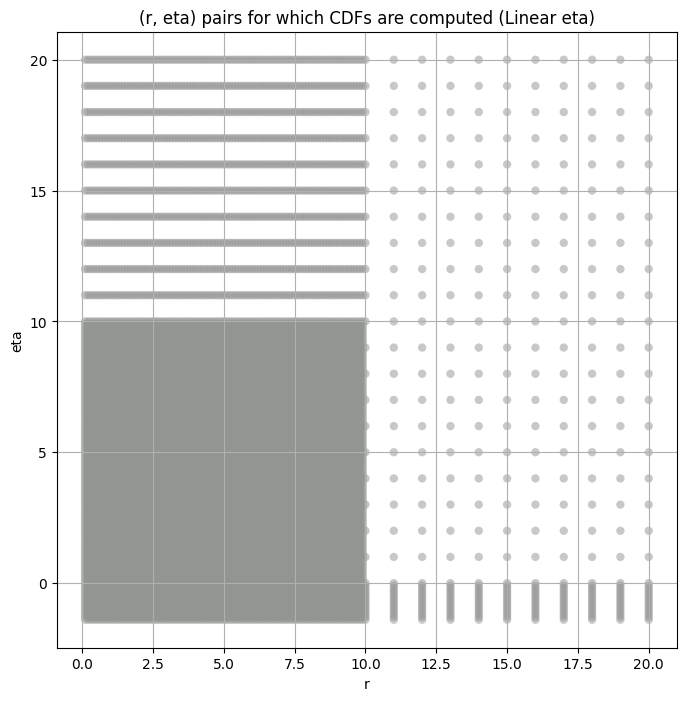

(r,eta),cdf    r  eta  \
0  ((0.1, -1.4), <scipy.interpolate._fitpack2.Int...  0.1 -1.4   
1  ((0.1, -1.3), <scipy.interpolate._fitpack2.Int...  0.1 -1.3   
2  ((0.1, -1.2), <scipy.interpolate._fitpack2.Int...  0.1 -1.2   
3  ((0.1, -1.1), <scipy.interpolate._fitpack2.Int...  0.1 -1.1   
4  ((0.1, -1.0), <scipy.interpolate._fitpack2.Int...  0.1 -1.0   

                                                 cdf      variance  \
0  <scipy.interpolate._fitpack2.InterpolatedUniva...  3.628800e+06   
1  <scipy.interpolate._fitpack2.InterpolatedUniva...  3.991680e+07   
2  <scipy.interpolate._fitpack2.InterpolatedUniva...  2.395008e+08   
3  <scipy.interpolate._fitpack2.InterpolatedUniva...  1.037837e+09   
4  <scipy.interpolate._fitpack2.InterpolatedUniva...  3.632429e+09   

        kurtosis  
0  554265.000000  
1   96192.272727  
2   29390.000000  
3   11997.692308  
4    5874.890110

In [8]:
warnings.filterwarnings('ignore', category=RuntimeWarning)

all_cdfs_df = create_kurt_var_ksstat_df(all_cdfs)
fine_cdfs_df = all_cdfs_df.copy()
all_cdfs_df = all_cdfs_df[(np.round(all_cdfs_df['r'], 1) == all_cdfs_df['r']) & (np.round(all_cdfs_df['eta'], 1) == all_cdfs_df['eta'])]
all_cdfs_df = all_cdfs_df.reset_index(drop=True)
all_cdfs = {x[0] : x[1] for x in all_cdfs_df["(r,eta),cdf"]}
                                             
var_values_dict = dict()
kurt_values_dict = dict()
master_df = pd.DataFrame(columns=[GROUP]).set_index(GROUP)
temp_cdf = all_cdfs_df
print(f"Running {all_cdfs_df.shape[0]} CDFs")
create_scatter_plot(all_cdfs_df);
all_cdfs_df.head()

## Bootstrapping the Variance and Kurtosis

In [9]:
n_bootstrap = int(1e5) # TODO For quick testing purposes
bootstrap_size = int(1e4) # TODO For quick testing purposes
ci = 0.99

In [10]:
bootstrap_path = Path(os.path.join(CWD, "CSVs", f'initial_grid_bootstrap{n_bootstrap}_{bootstrap_size}_ci{ci}.csv'))
master_df_var_kurt_path = Path(os.path.join(CWD, "CSVs", f'initial_grid_bootstrap{n_bootstrap}_{bootstrap_size}_ci{ci}.csv'))

if RERUN or not master_df_var_kurt_path.exists(): # TODO For quick testing purposes
    for group in GROUPS:
        print(f'{GROUP.capitalize()} {group}')
        obs_var, var_lower, var_upper, var_values_dict[group] = bootstrap_metric(group_data_map[group], 
                                                                                n_bootstrap=n_bootstrap, 
                                                                                bootstrap_size=min(group_data_map[group].size, bootstrap_size), 
                                                                                metric= np.var, 
                                                                                ci=ci)
        obs_kurt, kurt_lower, kurt_upper, kurt_values_dict[group] = bootstrap_metric(group_data_map[group], 
                                                                                    n_bootstrap=n_bootstrap, 
                                                                                    bootstrap_size=min(group_data_map[group].size, bootstrap_size), 
                                                                                    metric= stats.kurtosis, ci=ci)  
        master_df.loc[group, 'obs_var'], master_df.loc[group, 'var_lower'], master_df.loc[group, 'var_upper'] = obs_var, var_lower, var_upper
        master_df.loc[group, 'obs_kurt'], master_df.loc[group, 'kurt_lower'], master_df.loc[group, 'kurt_upper'] = obs_kurt, kurt_lower, kurt_upper
        master_df.loc[group, 'total_samples'] = group_total_samples[group]

    master_df.to_csv(os.path.join(CWD, "CSVs", f'initial_grid_bootstrap{n_bootstrap}_{bootstrap_size}_ci{ci}.csv'))

master_df = pd.read_csv(master_df_var_kurt_path, index_col=GROUP)
var_kurt_df = pd.read_csv(bootstrap_path, index_col=GROUP)
master_df

Band 2


  0%|          | 0/100000 [00:00<?, ?it/s]

  0%|          | 0/100000 [00:00<?, ?it/s]

Band 3


  0%|          | 0/100000 [00:00<?, ?it/s]

  0%|          | 0/100000 [00:00<?, ?it/s]

Band 5


  0%|          | 0/100000 [00:00<?, ?it/s]

  0%|          | 0/100000 [00:00<?, ?it/s]

Band 6


  0%|          | 0/100000 [00:00<?, ?it/s]

  0%|          | 0/100000 [00:00<?, ?it/s]

Band 8


  0%|          | 0/100000 [00:00<?, ?it/s]

  0%|          | 0/100000 [00:00<?, ?it/s]

Band 9


  0%|          | 0/100000 [00:00<?, ?it/s]

  0%|          | 0/100000 [00:00<?, ?it/s]

Band 11


  0%|          | 0/100000 [00:00<?, ?it/s]

  0%|          | 0/100000 [00:00<?, ?it/s]

Band 12


  0%|          | 0/100000 [00:00<?, ?it/s]

  0%|          | 0/100000 [00:00<?, ?it/s]

Band 14


  0%|          | 0/100000 [00:00<?, ?it/s]

  0%|          | 0/100000 [00:00<?, ?it/s]

Band 16


  0%|          | 0/100000 [00:00<?, ?it/s]

  0%|          | 0/100000 [00:00<?, ?it/s]

obs_var  var_lower  var_upper    obs_kurt  kurt_lower  kurt_upper  \
band                                                                       
2     0.006331   0.005661   0.007222   20.091526    8.301169   54.159079   
3     0.003786   0.003245   0.004591   45.824363   12.004293  112.151525   
5     2.128757   1.943052   2.320288    9.899200    8.736989   11.148364   
6     1.585753   1.449861   1.725575    9.456193    8.451809   10.508710   
8     0.193077   0.167066   0.222789   29.596515   20.241751   40.285456   
9     0.037816   0.033569   0.043264   21.922664   10.518936   59.659771   
11    0.016603   0.013695   0.020071   52.159590   32.308096   94.441255   
12    0.009694   0.007775   0.012055   70.446049   43.759223  129.165796   
14    0.000566   0.000441   0.000798  135.246009   42.063264  480.972013   
16    0.000128   0.000083   0.000198  298.160503  115.687456  695.444976   

      total_samples  
band                 
2           99231.0  
3          110499.0  
5         1094491.0  
6          552872.0  
8         3583528.0  
9         5376893.0  
11        6813712.0  
12       22438943.0  
14       12633705.0  
16        8261428.0

## Initial Grid Search and Hypothesis Test Plots

In [11]:
EXCLUDE_CUTOFFS = [0, 25, 50, 75, 100, 150, 200, 250, 300, 350, 500] # TODO For quick testing purposes
SCALE_CAP = 1e5

In [12]:
augmented_var_df_path = Path(os.path.join(CWD, "CSVs", "augmented_var_df.csv"))
augmented_var_df = var_kurt_df[['obs_var']].copy()
augmented_var_df
for val in EXCLUDE_CUTOFFS:
    temp_arr = []
    for group in GROUPS:
        if val != 0:
            temp_arr.append(np.var(group_data_map[group][val:-val]))
        else:
            temp_arr.append(np.var(group_data_map[group]))

    augmented_var_df[f"var_exclude_{val}"] = temp_arr
augmented_var_df

obs_var  var_exclude_0  var_exclude_25  var_exclude_50  var_exclude_75  \
band                                                                            
2     0.006331       0.006331        0.005918        0.005738        0.005606   
3     0.003786       0.003786        0.003394        0.003267        0.003169   
5     2.128757       2.128757        2.078477        2.036863        1.999171   
6     1.585753       1.585753        1.552305        1.522887        1.495717   
8     0.193077       0.193077        0.178621        0.169479        0.162324   
9     0.037816       0.037816        0.035281        0.034062        0.033137   
11    0.016603       0.016603        0.014873        0.013901        0.013148   
12    0.009694       0.009694        0.008509        0.007849        0.007340   
14    0.000566       0.000566        0.000481        0.000444        0.000416   
16    0.000128       0.000128        0.000091        0.000077        0.000067   

      var_exclude_100  var_exclude_150  var_exclude_200  var_exclude_250  \
band                                                                       
2            0.005495         0.005308         0.005150         0.005012   
3            0.003087         0.002950         0.002838         0.002745   
5            1.964157         1.900113         1.842497         1.789722   
6            1.470373         1.423641         1.380877         1.341437   
8            0.156378         0.146764         0.139101         0.132695   
9            0.032367         0.031103         0.030059         0.029156   
11           0.012521         0.011504         0.010693         0.010016   
12           0.006917         0.006234         0.005693         0.005244   
14           0.000392         0.000355         0.000325         0.000300   
16           0.000059         0.000048         0.000041         0.000035   

      var_exclude_300  var_exclude_350  var_exclude_500  
band                                                     
2            0.004887         0.004774         0.004483  
3            0.002664         0.002592         0.002407  
5            1.740792         1.695001         1.573210  
6            1.304857         1.270564         1.178805  
8            0.127177         0.122335         0.110561  
9            0.028352         0.027624         0.025760  
11           0.009437         0.008933         0.007733  
12           0.004863         0.004533         0.003758  
14           0.000280         0.000261         0.000218  
16           0.000031         0.000028         0.000021

####
Band  2


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
2 0 0.0015756005262785866 0.006330872151264366


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
2 25 0.004036456283064316 0.005918172114514947


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
2 50 0.004460038899385732 0.0057376493790155005


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
2 75 0.004818707248981202 0.005605770268518691


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
2 100 0.005138125625837764 0.005494906325753141


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
2 150 0.0036452393018870932 0.005308200657259015


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
2 200 0.004879339034897678 0.005149964065534939


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
2 250 0.005773316895425817 0.005011699722446957


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
2 300 0.006213705123613238 0.0048873938789884


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
2 350 0.00727925862294132 0.00477427882545263


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
2 500 0.008732060619353499 0.004482731689354495
Number of samples: 100000, Without approximation : 99231.0


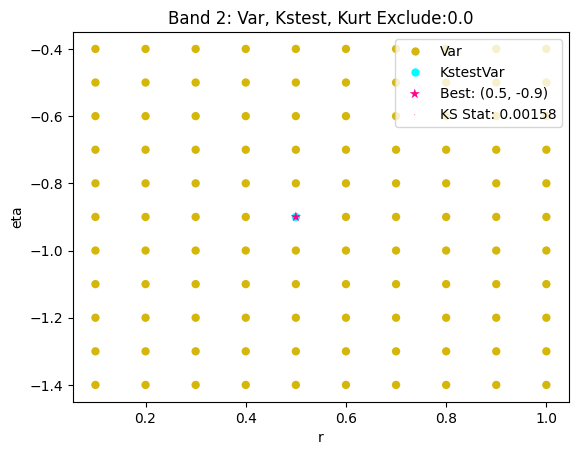

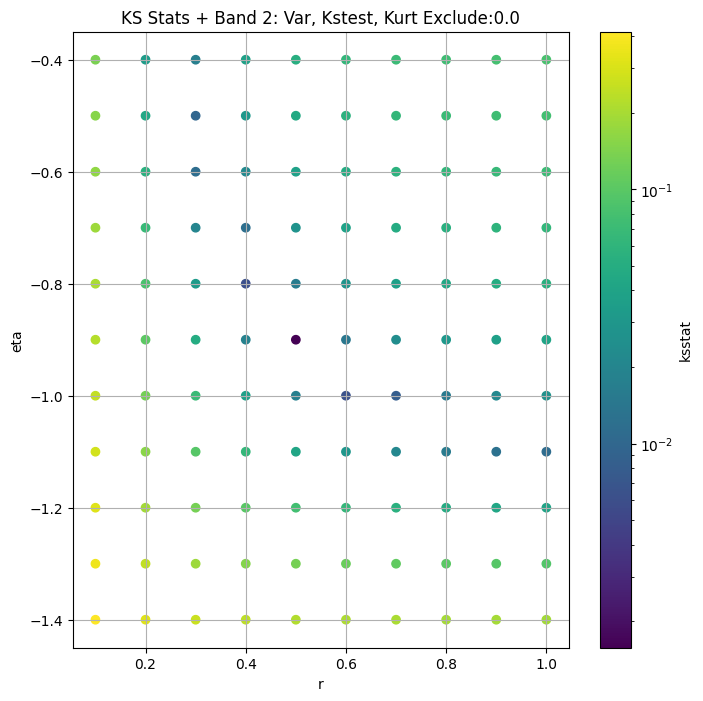

####
Band  3


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
3 0 0.0033769732863462576 0.0037856469768739816


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
3 25 0.0035786671206708975 0.003394387594949548


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
3 50 0.004771775728202421 0.0032667273678625396


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
3 75 0.0043002148565499665 0.0031690763430332757


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
3 100 0.00423655443581164 0.0030867494071687494


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
3 150 0.004047225467778571 0.002949709379164048


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
3 200 0.005336031797903831 0.002838380953697132


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
3 250 0.005219837063434762 0.0027448030664962205


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
3 300 0.005831822770451828 0.0026640960163753034


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
3 350 0.006611455826708225 0.0025918075556730998


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
3 500 0.008062071530338746 0.002407131499910721
Number of samples: 100000, Without approximation : 110499.0


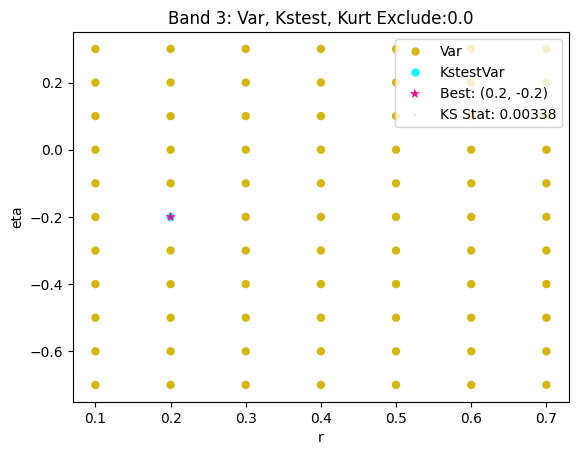

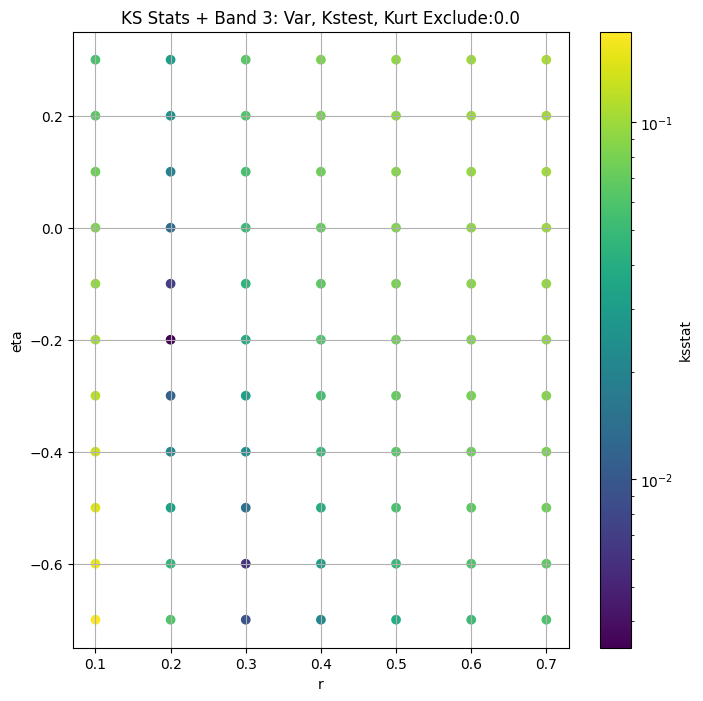

####
Band  5


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
5 0 0.016258952509934144 2.1287566066216677


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
5 25 0.0167815436594769 2.0784765972554893


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
5 50 0.017557859346587018 2.036862555533208


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
5 75 0.01827158677097826 1.9991705241211168


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
5 100 0.01894361791731769 1.964156943673045


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
5 150 0.02019768956803146 1.9001134304697793


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
5 200 0.01954586568839556 1.8424966131195784


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
5 250 0.018223840305193084 1.7897222611272308


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
5 300 0.01695810765927863 1.7407917701176776


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
5 350 0.016631290277787092 1.695001277748207


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
5 500 0.01936348123844933 1.5732103187122366
Number of samples: 100000, Without approximation : 1094491.0


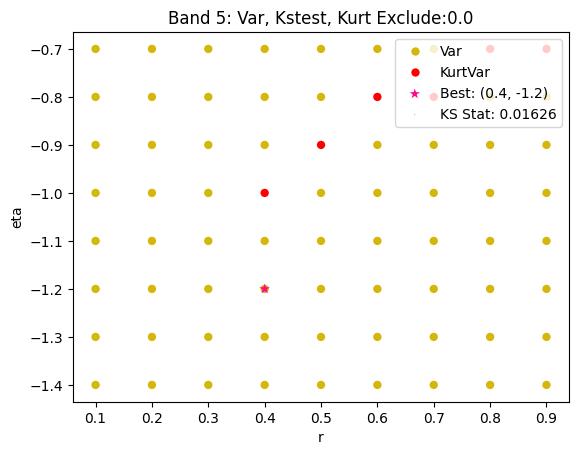

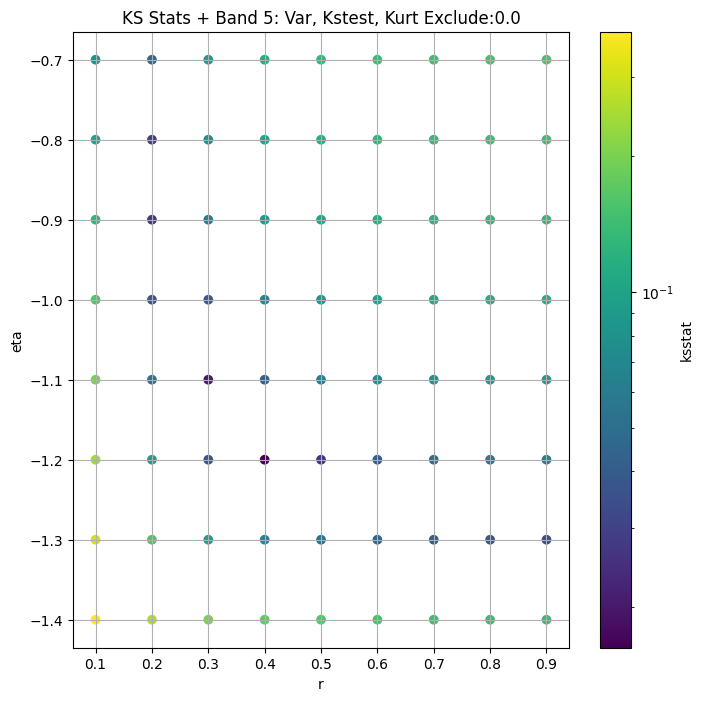

####
Band  6


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
6 0 0.014426992680936293 1.5857533614804338


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
6 25 0.014545121609302769 1.5523046401155676


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
6 50 0.01357392467698515 1.5228869628381416


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
6 75 0.012666493587306649 1.4957170107145554


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
6 100 0.012241761936374843 1.4703728082985128


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
6 150 0.013496760003969266 1.4236406690805834


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
6 200 0.014723197743531605 1.3808765963798801


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
6 250 0.015877214039223403 1.3414368930320395


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
6 300 0.016980066042958222 1.3048566477731325


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
6 350 0.01648931504208684 1.2705639102038688


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
6 500 0.014774605696553922 1.178804509077788
Number of samples: 100000, Without approximation : 552872.0


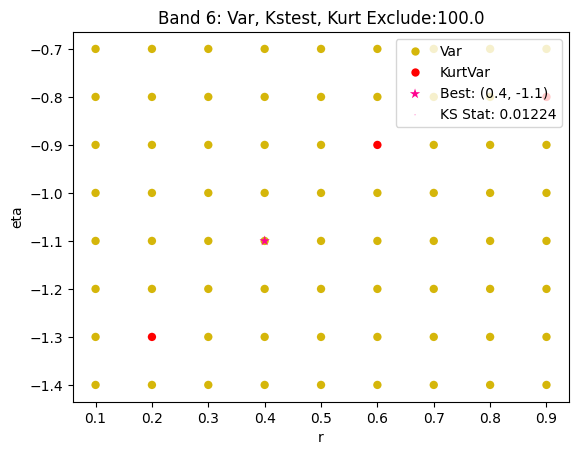

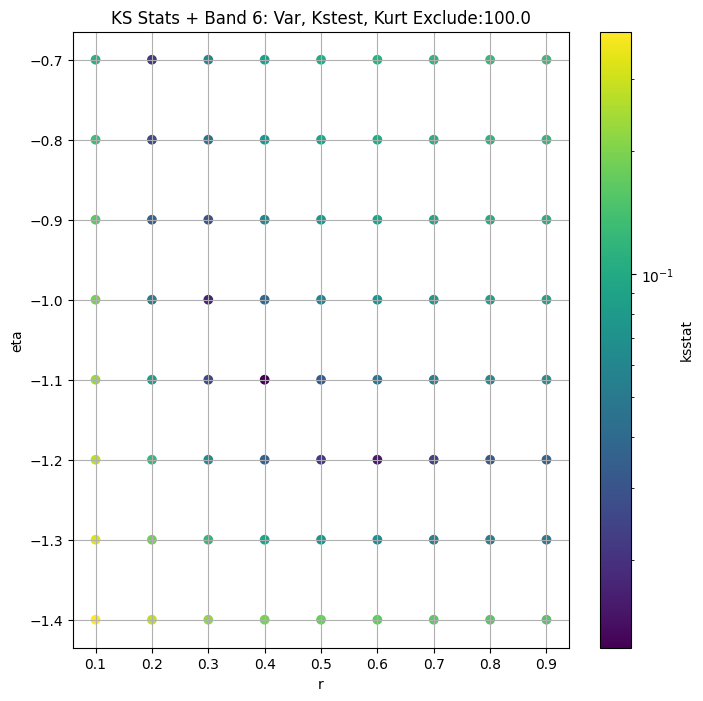

####
Band  8


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
8 0 0.010335118961035561 0.19307669797530216


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
8 25 0.006397838645939236 0.17862081624243553


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
8 50 0.003956593407791711 0.16947920660468543


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
8 75 0.006353483665598653 0.16232442886175072


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
8 100 0.006642051350973344 0.15637750065781364


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
8 150 0.005455168885569739 0.14676386626139784


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
8 200 0.005936351876772619 0.1391008498418871


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
8 250 0.008409451366913942 0.13269460388264437


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
8 300 0.0075204572937217495 0.12717697081235568


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
8 350 0.005536090057797226 0.12233491626313439


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
8 500 0.009193252620224121 0.11056095319136537
Number of samples: 100000, Without approximation : 3583528.0


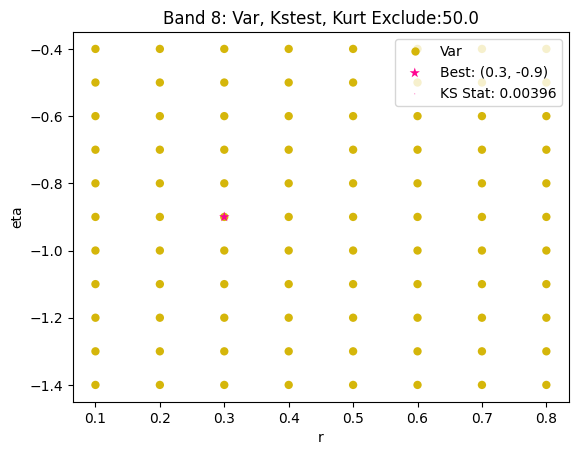

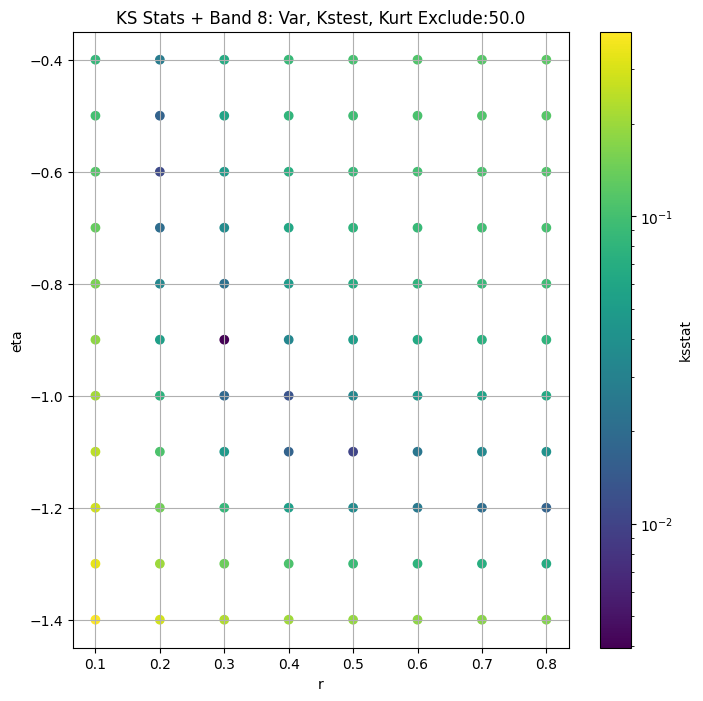

####
Band  9


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
9 0 0.00741986263938052 0.037815678653209346


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
9 25 0.0049828942123825715 0.03528077195112672


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
9 50 0.005446153897974038 0.03406186685523836


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
9 75 0.005829113861151092 0.033137307471927335


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
9 100 0.006180180300510263 0.03236697326031578


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
9 150 0.006265602578263696 0.031102804162478716


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
9 200 0.006304210658611004 0.030059234429326877


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
9 250 0.007624170416272724 0.029156229951172473


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
9 300 0.008565171325291665 0.028351975572621792


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
9 350 0.00815880386576897 0.027624170948969157


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
9 500 0.009939523544940244 0.025759971589400597
Number of samples: 100000, Without approximation : 5376893.0


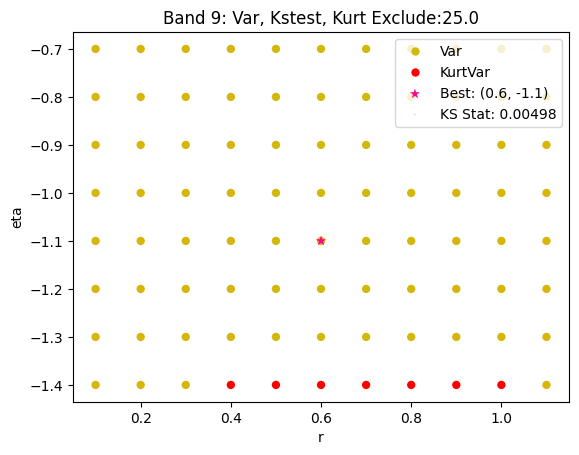

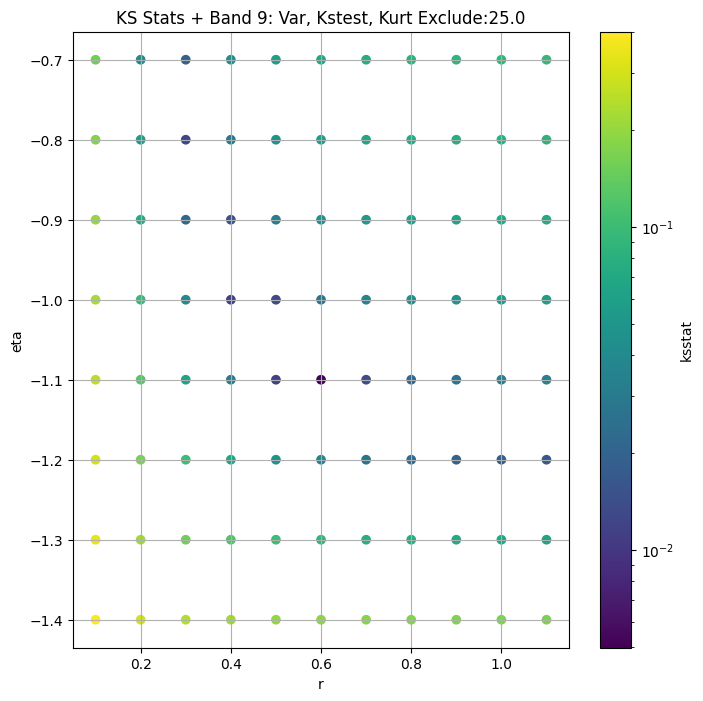

####
Band  11


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
11 0 0.010343478946444606 0.0166032489332338


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
11 25 0.011073958972347475 0.01487344985353461


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
11 50 0.013491921060136747 0.013901440090807413


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
11 75 0.010898660619554246 0.01314800038685783


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
11 100 0.0086573280294302 0.012520898634945371


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
11 150 0.007414984930988591 0.011504407497533726


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
11 200 0.009818202078956353 0.010692502767010469


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
11 250 0.01221473804510774 0.010016235385457732


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
11 300 0.014178728010155017 0.00943679676771235


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
11 350 0.014644837085864726 0.008932761059894503


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
11 500 0.01604308558593654 0.007732967616505784
Number of samples: 100000, Without approximation : 6813712.0


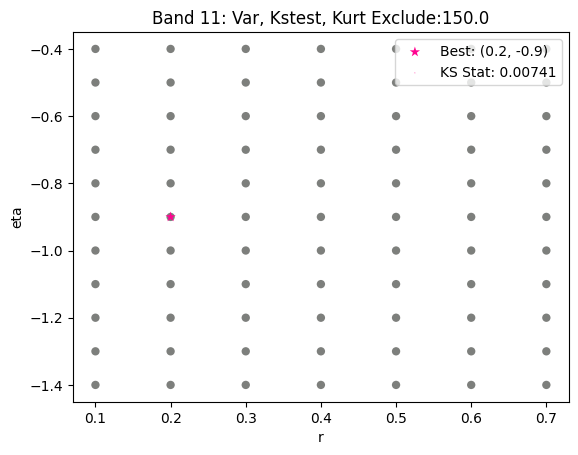

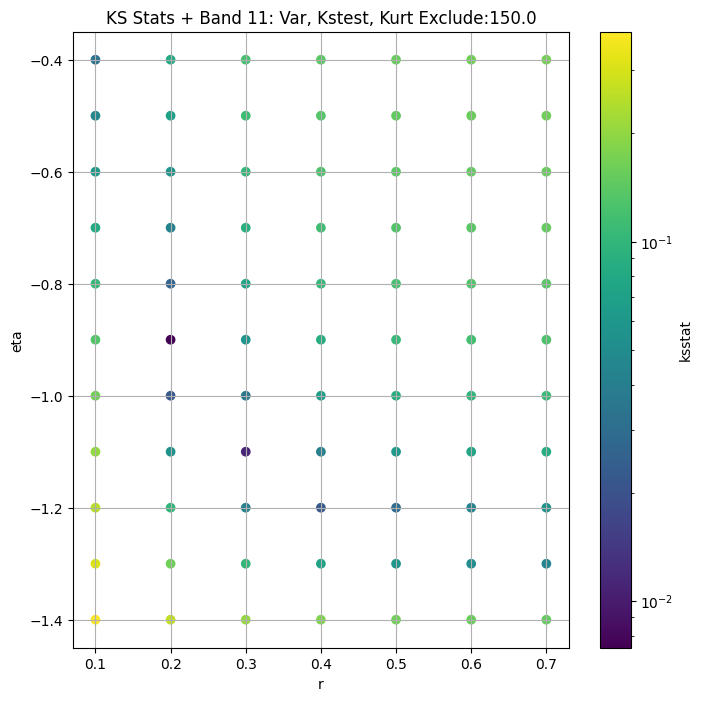

####
Band  12


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
12 0 0.009459583250684966 0.009694315800875913


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
12 25 0.007231508135754128 0.008509341094612068


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
12 50 0.009504389522180967 0.007848767501918692


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
12 75 0.007192049558732649 0.007339761310532874


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
12 100 0.005910207480405473 0.006917080760549033


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
12 150 0.007240407238075043 0.006233999046031464


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
12 200 0.007928996676024092 0.0056927059659624395


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
12 250 0.00865331209127217 0.005244345955713017


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
12 300 0.00983854277454117 0.004863042317447353


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
12 350 0.010130575885212378 0.004533209145171132


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
12 500 0.010016329984756971 0.003758319700450599
Number of samples: 100000, Without approximation : 22438943.0


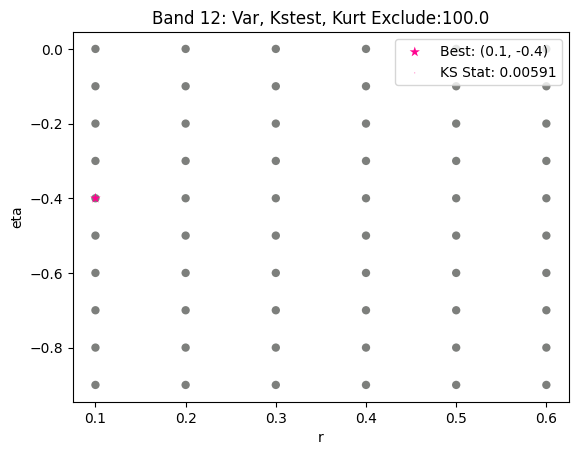

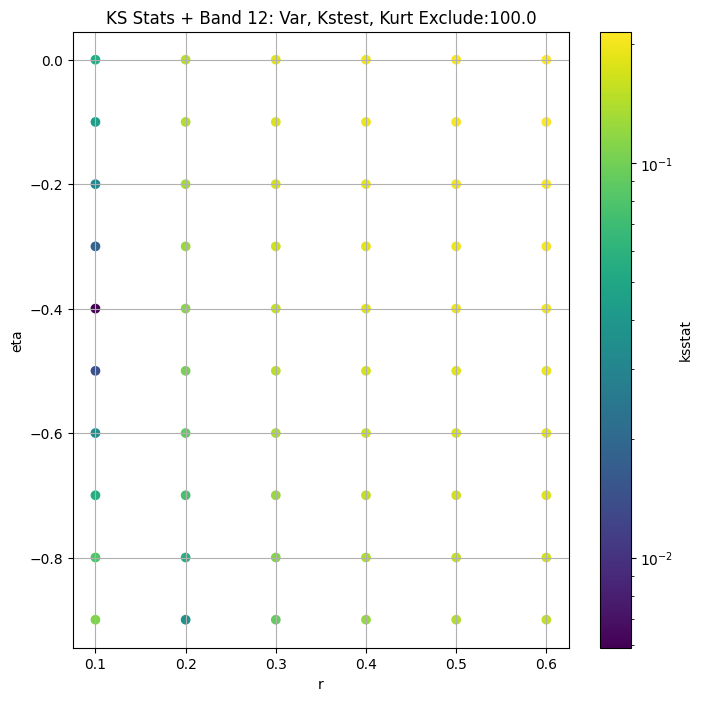

####
Band  14


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
14 0 0.013106943694013329 0.0005655224950827032


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
14 25 0.012629049833468908 0.0004808046698492311


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
14 50 0.009142933909353279 0.00044381419370733815


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
14 75 0.011334453354183815 0.00041560421367028126


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
14 100 0.01166580851502752 0.00039236169153568866


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
14 150 0.006048563144146757 0.00035485166428875665


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
14 200 0.009050693579002789 0.00032513145088210497


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
14 250 0.007504374970711153 0.00030046150530263716


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
14 300 0.00850044015610987 0.0002795027440028938


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
14 350 0.00887608987039376 0.00026132535911132826


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
14 500 0.009497586414615677 0.00021844982613017434
Number of samples: 100000, Without approximation : 12633705.0


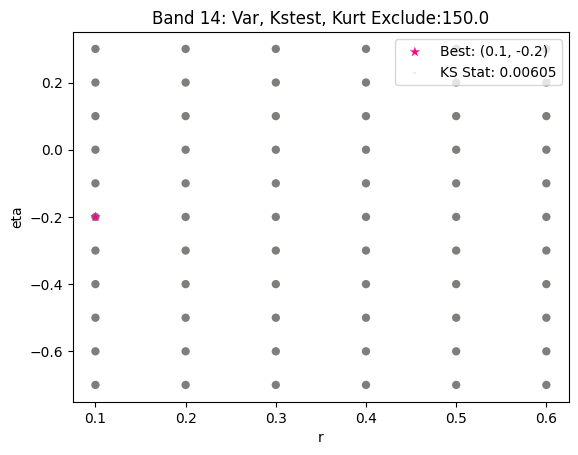

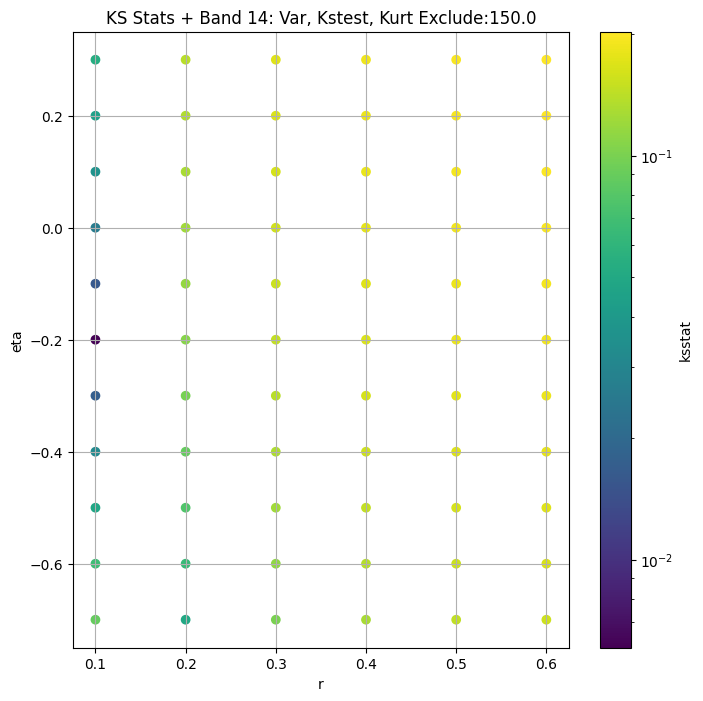

####
Band  16


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
16 0 0.02806755912599551 0.00012810603317243562


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
16 25 0.02636598953849001 9.140592527617673e-05


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
16 50 0.02556723142477102 7.659366094149841e-05


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
16 75 0.024590077063990856 6.666179598716728e-05


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
16 100 0.018721148778222285 5.921132303463837e-05


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
16 150 0.020805511878622562 4.847772846820522e-05


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
16 200 0.016234439087064734 4.0985293547516937e-05


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
16 250 0.015501850648308335 3.540800940671834e-05


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
16 300 0.013336867233545158 3.1098151378325334e-05


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
16 350 0.012443470000915724 2.7681846851114835e-05


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
16 500 0.008558397458322136 2.0657479649819092e-05
Number of samples: 100000, Without approximation : 8261428.0


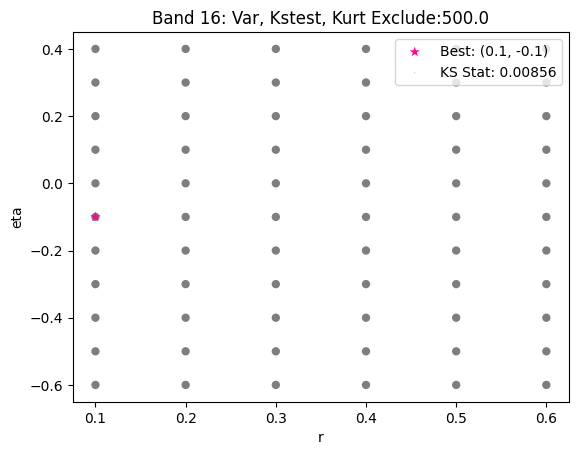

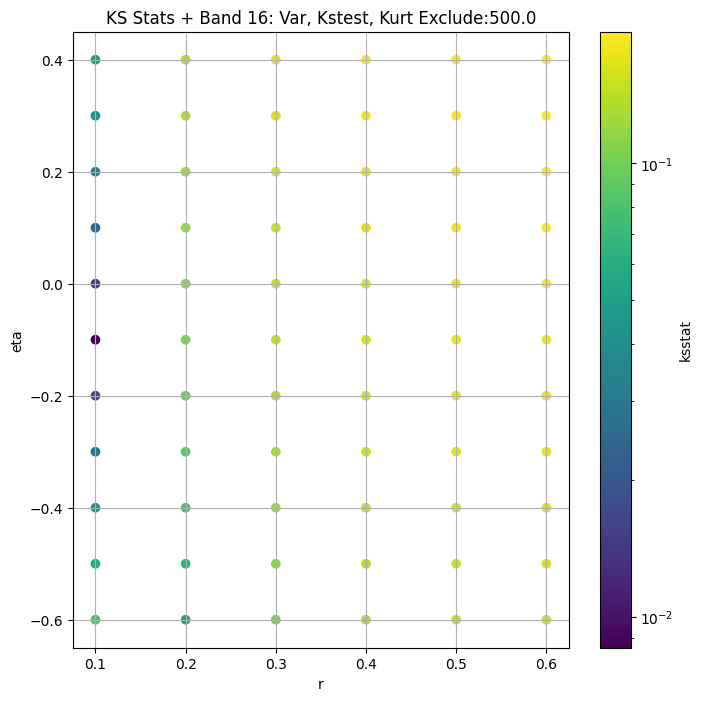

obs_var  var_lower  var_upper    obs_kurt  kurt_lower  kurt_upper  \
band                                                                       
2     0.006331   0.005661   0.007222   20.091526    8.301169   54.159079   
3     0.003786   0.003245   0.004591   45.824363   12.004293  112.151525   
5     2.128757   1.943052   2.320288    9.899200    8.736989   11.148364   
6     1.585753   1.449861   1.725575    9.456193    8.451809   10.508710   
8     0.193077   0.167066   0.222789   29.596515   20.241751   40.285456   
9     0.037816   0.033569   0.043264   21.922664   10.518936   59.659771   
11    0.016603   0.013695   0.020071   52.159590   32.308096   94.441255   
12    0.009694   0.007775   0.012055   70.446049   43.759223  129.165796   
14    0.000566   0.000441   0.000798  135.246009   42.063264  480.972013   
16    0.000128   0.000083   0.000198  298.160503  115.687456  695.444976   

      total_samples  kstest_stat_initial  initial_r  initial_eta  \
band                                                               
2           99231.0             0.001576        0.5         -0.9   
3          110499.0             0.003377        0.2         -0.2   
5         1094491.0             0.016259        0.4         -1.2   
6          552872.0             0.012242        0.4         -1.1   
8         3583528.0             0.003957        0.3         -0.9   
9         5376893.0             0.004983        0.6         -1.1   
11        6813712.0             0.007415        0.2         -0.9   
12       22438943.0             0.005910        0.1         -0.4   
14       12633705.0             0.006049        0.1         -0.2   
16        8261428.0             0.008558        0.1         -0.1   

      initial_scale  initial_exclude_cutoff  best_augmented_var  \
band                                                              
2      2.398058e-03                     0.0            0.006331   
3      9.158696e-08                     0.0            0.003786   
5      1.023284e+00                     0.0            2.128757   
6      4.424368e-01                   100.0            1.470373   
8      4.223364e-03                    50.0            0.169479   
9      4.012493e-02                    25.0            0.035281   
11     4.565241e-06                   150.0            0.011504   
12     1.031719e-14                   100.0            0.006917   
14     1.512228e-16                   150.0            0.000355   
16     4.975804e-18                   500.0            0.000021   

      kstest_stat_cutoff_0.05  
band                           
2                    0.004310  
3                    0.004084  
5                    0.001298  
6                    0.001826  
8                    0.000717  
9                    0.000586  
11                   0.000520  
12                   0.000287  
14                   0.000382  
16                   0.000472

In [13]:
master_df_combo_path = Path(os.path.join(CWD, "CSVs", "master_df_combo.csv"))
rEtaKsstats_dict_path = Path(os.path.join(CWD, "cache", "rEtaKsstats_dict.pickle"))

rEtaKsstats_dict = dict()

if RERUN or not master_df_combo_path.exists():
    sorted_params = sorted(all_cdfs)
    ksstats_dict = dict()

    for i, group in enumerate(GROUPS): # TODO For quick testing purposes
        print(f"####\n{GROUP.capitalize()} ", group)
        sample = group_data_map[group]
        if len(sample) == 0:
            continue
        group_cdfs_df = all_cdfs_df.copy()
        master_df.loc[group, 'kstest_stat_initial'] = 1

        for j in range(len(EXCLUDE_CUTOFFS)):

            exclude_cutoff = EXCLUDE_CUTOFFS[j]
            exclude_cutoff = int(exclude_cutoff)

            if exclude_cutoff == 0:
                augmented_var = np.var(group_data_map[group]) 
            else:
                augmented_var = np.var(group_data_map[group][exclude_cutoff:-exclude_cutoff])
                if augmented_var == np.var(group_data_map[group]):
                    continue 
                
            group_cdfs_df['scale'] = np.clip((augmented_var / group_cdfs_df['variance']), 0,  SCALE_CAP)
            ksstats, initial_param, min_stat = gridsearch(sample, all_cdfs, debug=True, scales=group_cdfs_df['scale'])
            augmented_var_df.loc[group, f"kstest_stat_{exclude_cutoff}"] = min_stat
            group_cdfs_df[f'ksstat_exclude_{exclude_cutoff}'] = ksstats
            
            print(group, exclude_cutoff, min_stat, augmented_var)
            
            if (min_stat < master_df.loc[group, 'kstest_stat_initial']) and not np.isclose(min_stat, master_df.loc[group, 'kstest_stat_initial'], 1e-6):
                inital_min_stat = min_stat
                inital_best_param = initial_param
                master_df.loc[group, 'kstest_stat_initial'] = min_stat
                initial_scale = group_cdfs_df.loc[(group_cdfs_df["r"] ==  initial_param[0]) & (group_cdfs_df["eta"] ==  initial_param[1])]["scale"].iloc[0]
                master_df.loc[group, 'initial_r'], master_df.loc[group, 'initial_eta'] = initial_param
                master_df.loc[group, 'initial_scale'] = initial_scale
                master_df.loc[group, 'initial_exclude_cutoff'] = exclude_cutoff
                master_df.loc[group, 'best_augmented_var'] = augmented_var
        
        ksstats = group_cdfs_df[f"ksstat_exclude_{int(master_df.loc[group, 'initial_exclude_cutoff'])}"]
            
        print(f"Number of samples: {sample.size}, Without approximation : {master_df.loc[group, 'total_samples']}")
        
        cutoff = stats.kstwo(n=master_df.loc[group, 'total_samples']).isf(0.05)
        master_df.loc[group, 'kstest_stat_cutoff_0.05'] = cutoff

        best_scales = np.clip((master_df.loc[group, 'best_augmented_var'] / group_cdfs_df['variance']), 0,  SCALE_CAP)

        group_cdfs_df['variance'] = group_cdfs_df['variance'] * best_scales
        group_cdfs_df['kurtosis'] = group_cdfs_df['kurtosis'] * best_scales

        group_cdfs_df = add_tests_to_df(cdfs_df = group_cdfs_df, group = group, var_kurt_df = master_df, ksstats = ksstats).sort_values(['r', 'eta'])

        group_dict = {'r' : group_cdfs_df['r'], 'eta' : group_cdfs_df['eta']}
        group_dict.update({f'ksstat_exclude_{exclude_cutoff}' : group_cdfs_df[f'ksstat_exclude_{exclude_cutoff}'] for exclude_cutoff in EXCLUDE_CUTOFFS[:j+1]})
        rEtaKsstats_dict[group] = group_dict

        cols = ['pass_var', 'pass_kstest', 'pass_kurt']

        fig = combo_test_plot(group_cdfs_df, cols, 
                            plot_name=f"{GROUP.capitalize()} {group}: {', '.join([col[5:].capitalize() for col in cols])} Exclude:{master_df.loc[group, 'initial_exclude_cutoff']}", 
                            target_var = None,
                            best_param = inital_best_param,
                            best_ksstat=inital_min_stat
                            )
        
        fig.figure.savefig(os.path.join(CWD, "plots", f"full_grid_search_combo_plot_layer{group}.jpg"), bbox_inches = 'tight', dpi=100)

        # Optional: 
        # Create plots of bootstrapped variance and kurtosis for varying confidence intervals
        # fig_var = create_ci_scatter_plot(group_cdfs_df, var_values_dict, metric='variance', group=group)
        # fig_kurt = create_ci_scatter_plot(group_cdfs_df, kurt_values_dict, metric='kurtosis', group=group)

        # fig_var.savefig(os.path.join(CWD, "plots", f"ci_scatter_variance_{GROUP}_{group}_bootstrap{n_bootstrap}.jpg"), bbox_inches='tight')
        # plt.close(fig_var)
        # fig_kurt.savefig(os.path.join(CWD, "plots", f"ci_scatter_variance_{GROUP}_{group}_bootstrap{n_bootstrap}.jpg"), bbox_inches='tight')
        # plt.close(fig_kurt)

    master_df.to_csv(master_df_combo_path)
    pd.to_pickle(rEtaKsstats_dict, rEtaKsstats_dict_path)
    augmented_var_df.to_csv(augmented_var_df_path)

augmented_var_df = pd.read_csv(augmented_var_df_path, index_col=GROUP)
master_df = pd.read_csv(master_df_combo_path, index_col=GROUP)
rEtaKsstats_dict = pd.read_pickle(rEtaKsstats_dict_path)
master_df

## Optimization

In [14]:
master_df['kstest_stat_best'] = master_df['kstest_stat_initial']
master_df[f'best_r'] = master_df['initial_r']
master_df[f'best_eta'] = master_df['initial_eta']
master_df[f'best_scale'] = master_df['initial_scale']
master_df[f'best_exclude_cutoff'] = master_df['initial_exclude_cutoff']

Band 2


  0%|          | 0/1790 [00:00<?, ?it/s]

Finding Minimum after computing 1790 CDFs
band 2, 0.0 + 100 = 100, ksstat: 0.003109921965430411, var: 0.005494906325753141


  0%|          | 0/1790 [00:00<?, ?it/s]

Finding Minimum after computing 1790 CDFs
band 2, 0.0 + 75 = 75, ksstat: 0.003269793200270432, var: 0.005605770268518691


  0%|          | 0/1790 [00:00<?, ?it/s]

Finding Minimum after computing 1790 CDFs
band 2, 0.0 + 50 = 50, ksstat: 0.00252866255387605, var: 0.0057376493790155005


  0%|          | 0/1790 [00:00<?, ?it/s]

Finding Minimum after computing 1790 CDFs
band 2, 0.0 + 25 = 25, ksstat: 0.002344805342479883, var: 0.005918172114514947


  0%|          | 0/1790 [00:00<?, ?it/s]

Finding Minimum after computing 1790 CDFs
band 2, 0.0 + 0 = 0, ksstat: 0.0015756005262785866, var: 0.006330872151264366
Number of samples: 100000, Without approximation : 99231.0


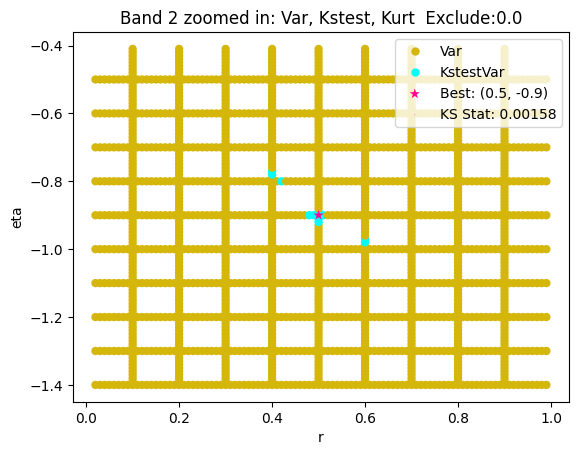

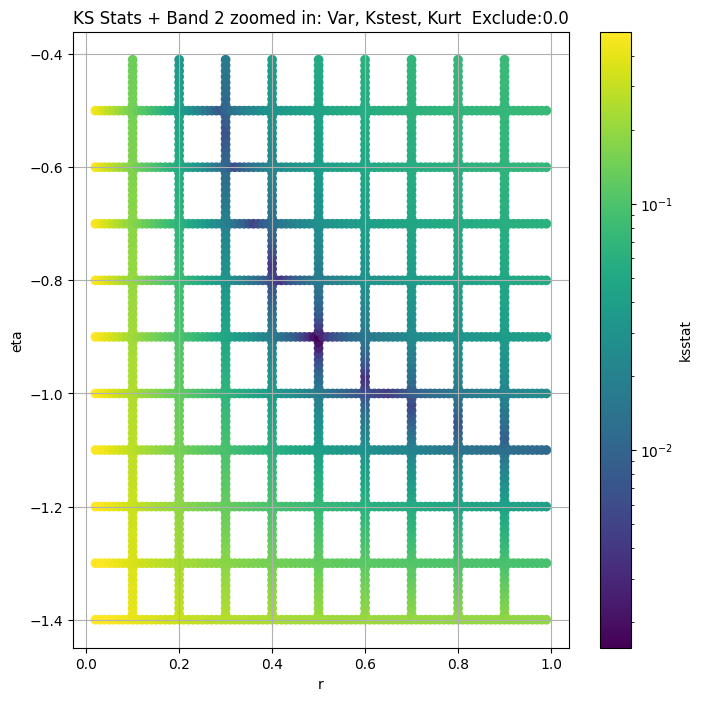

Band 3


  0%|          | 0/1131 [00:00<?, ?it/s]

Finding Minimum after computing 1131 CDFs
band 3, 0.0 + 100 = 100, ksstat: 0.003015467789679784, var: 0.0030867494071687494


  0%|          | 0/1131 [00:00<?, ?it/s]

Finding Minimum after computing 1131 CDFs
band 3, 0.0 + 75 = 75, ksstat: 0.0024644625024988695, var: 0.0031690763430332757


  0%|          | 0/1131 [00:00<?, ?it/s]

Finding Minimum after computing 1131 CDFs
band 3, 0.0 + 50 = 50, ksstat: 0.0019378450688438686, var: 0.0032667273678625396


  0%|          | 0/1131 [00:00<?, ?it/s]

Finding Minimum after computing 1131 CDFs
band 3, 0.0 + 25 = 25, ksstat: 0.001327756307557399, var: 0.003394387594949548


  0%|          | 0/1131 [00:00<?, ?it/s]

Finding Minimum after computing 1131 CDFs
band 3, 0.0 + 0 = 0, ksstat: 0.0021682375421023803, var: 0.0037856469768739816
Number of samples: 100000, Without approximation : 110499.0


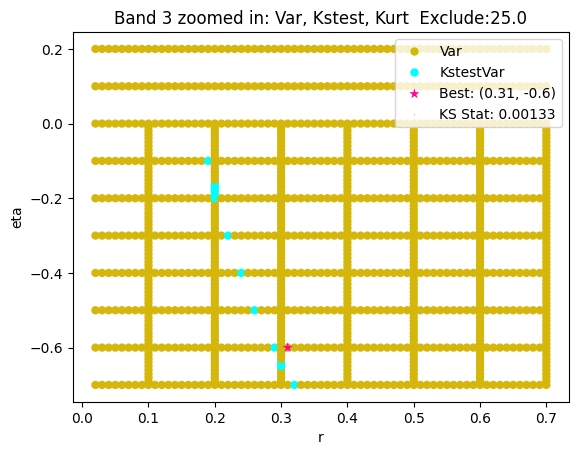

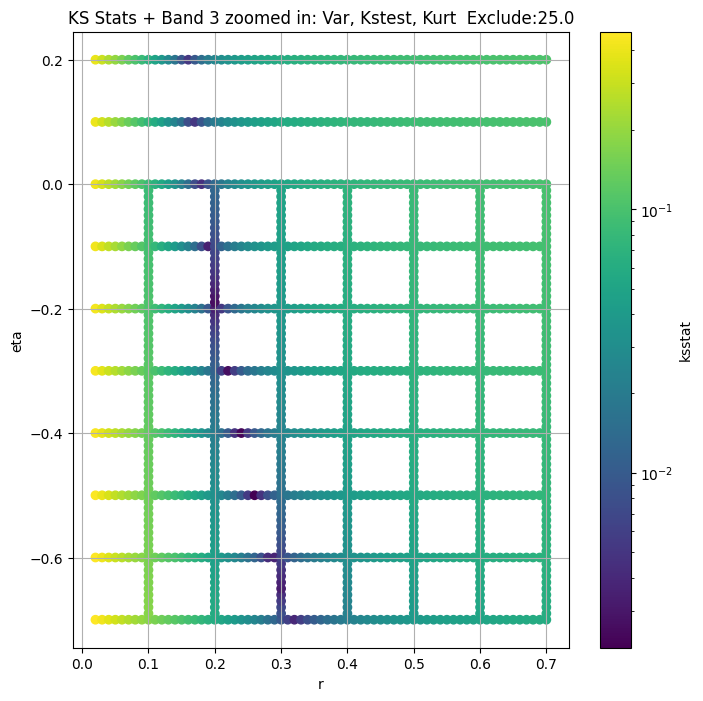

Band 5


  0%|          | 0/1160 [00:00<?, ?it/s]

Finding Minimum after computing 1160 CDFs
band 5, 0.0 + 100 = 100, ksstat: 0.014396714013395914, var: 1.964156943673045


  0%|          | 0/1160 [00:00<?, ?it/s]

Finding Minimum after computing 1160 CDFs
band 5, 0.0 + 75 = 75, ksstat: 0.013986255380248336, var: 1.9991705241211168


  0%|          | 0/1160 [00:00<?, ?it/s]

Finding Minimum after computing 1160 CDFs
band 5, 0.0 + 50 = 50, ksstat: 0.013817008951481545, var: 2.036862555533208


  0%|          | 0/1160 [00:00<?, ?it/s]

Finding Minimum after computing 1160 CDFs
band 5, 0.0 + 25 = 25, ksstat: 0.013644557460999573, var: 2.0784765972554893


  0%|          | 0/1160 [00:00<?, ?it/s]

Finding Minimum after computing 1160 CDFs
band 5, 0.0 + 0 = 0, ksstat: 0.013492473756431589, var: 2.1287566066216677
Number of samples: 100000, Without approximation : 1094491.0


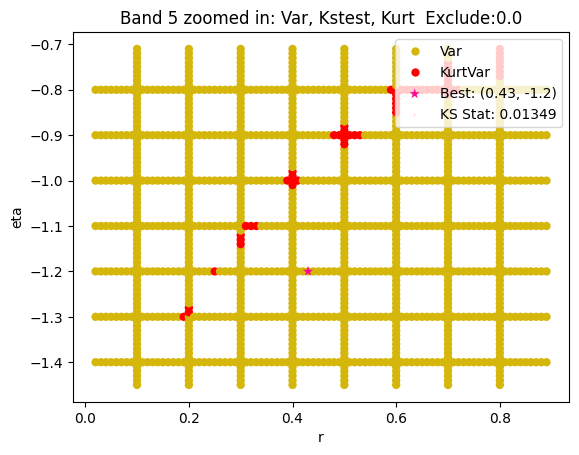

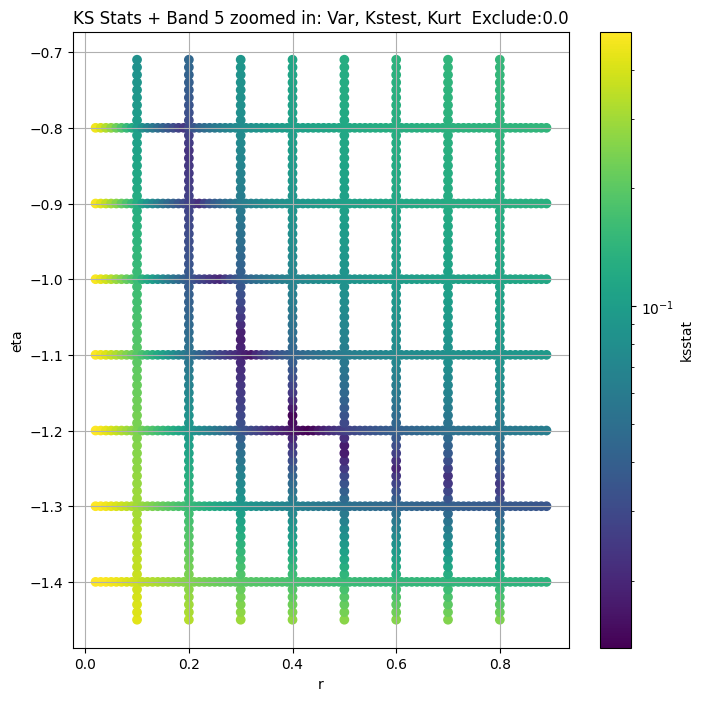

Band 6


  0%|          | 0/1320 [00:00<?, ?it/s]

Finding Minimum after computing 1320 CDFs
band 6, 100.0 + 100 = 200, ksstat: 0.01150802326185732, var: 1.3808765963798801


  0%|          | 0/1320 [00:00<?, ?it/s]

Finding Minimum after computing 1320 CDFs
band 6, 100.0 + 75 = 175, ksstat: 0.011269608114116259, var: 1.4018193679587894


  0%|          | 0/1320 [00:00<?, ?it/s]

Finding Minimum after computing 1320 CDFs
band 6, 100.0 + 50 = 150, ksstat: 0.012052560114834132, var: 1.4236406690805834


  0%|          | 0/1320 [00:00<?, ?it/s]

Finding Minimum after computing 1320 CDFs
band 6, 100.0 + 25 = 125, ksstat: 0.01278207307583501, var: 1.4464467757980417


  0%|          | 0/1320 [00:00<?, ?it/s]

Finding Minimum after computing 1320 CDFs
band 6, 100.0 + 0 = 100, ksstat: 0.012241761936374843, var: 1.4703728082985128


  0%|          | 0/1320 [00:00<?, ?it/s]

Finding Minimum after computing 1320 CDFs
band 6, 100.0 + -25 = 75, ksstat: 0.012147632174672796, var: 1.4957170107145554


  0%|          | 0/1320 [00:00<?, ?it/s]

Finding Minimum after computing 1320 CDFs
band 6, 100.0 + -50 = 50, ksstat: 0.011454695071262837, var: 1.5228869628381416


  0%|          | 0/1320 [00:00<?, ?it/s]

Finding Minimum after computing 1320 CDFs
band 6, 100.0 + -75 = 25, ksstat: 0.011334162613297644, var: 1.5523046401155676


  0%|          | 0/1320 [00:00<?, ?it/s]

Finding Minimum after computing 1320 CDFs
band 6, 100.0 + -100 = 0, ksstat: 0.010499292810674125, var: 1.5857533614804338
Number of samples: 100000, Without approximation : 552872.0


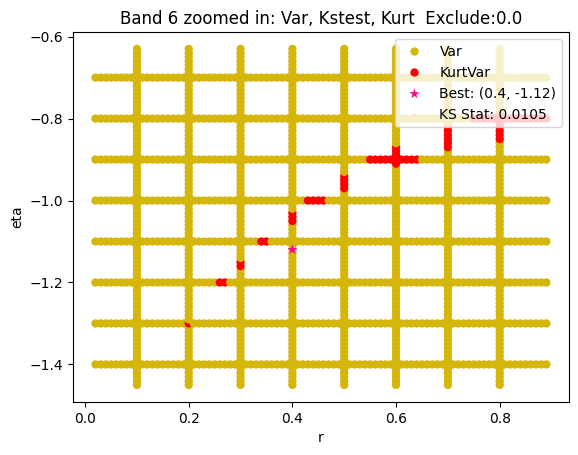

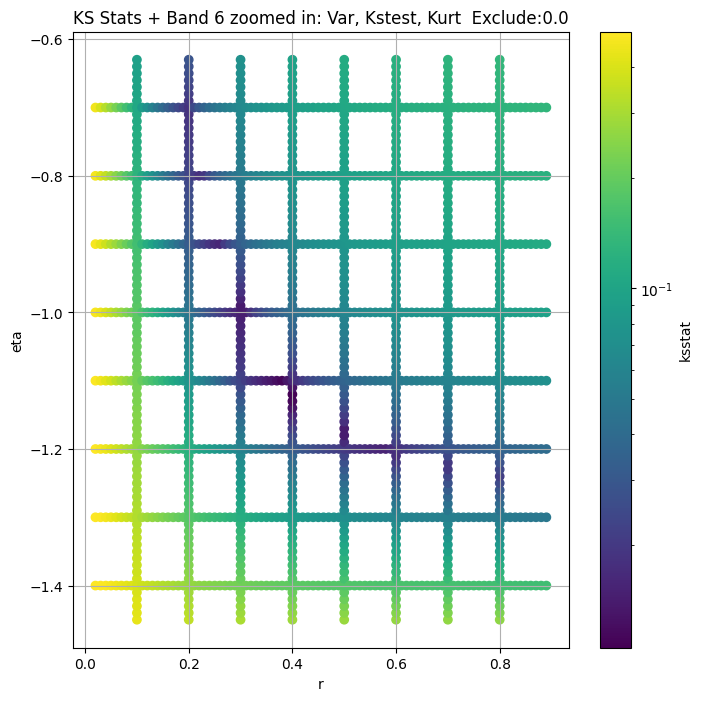

Band 8


  0%|          | 0/1410 [00:00<?, ?it/s]

Finding Minimum after computing 1410 CDFs
band 8, 50.0 + 100 = 150, ksstat: 0.003922361573668334, var: 0.14676386626139784


  0%|          | 0/1410 [00:00<?, ?it/s]

Finding Minimum after computing 1410 CDFs
band 8, 50.0 + 75 = 125, ksstat: 0.0031721476493016126, var: 0.15125746850626767


  0%|          | 0/1410 [00:00<?, ?it/s]

Finding Minimum after computing 1410 CDFs
band 8, 50.0 + 50 = 100, ksstat: 0.0032134310969235136, var: 0.15637750065781364


  0%|          | 0/1410 [00:00<?, ?it/s]

Finding Minimum after computing 1410 CDFs
band 8, 50.0 + 25 = 75, ksstat: 0.002929520851591927, var: 0.16232442886175072


  0%|          | 0/1410 [00:00<?, ?it/s]

Finding Minimum after computing 1410 CDFs
band 8, 50.0 + 0 = 50, ksstat: 0.002368253709951973, var: 0.16947920660468543


  0%|          | 0/1410 [00:00<?, ?it/s]

Finding Minimum after computing 1410 CDFs
band 8, 50.0 + -25 = 25, ksstat: 0.0024709857391877477, var: 0.17862081624243553


  0%|          | 0/1410 [00:00<?, ?it/s]

Finding Minimum after computing 1410 CDFs
band 8, 50.0 + -50 = 0, ksstat: 0.00210960461555576, var: 0.19307669797530216
Number of samples: 100000, Without approximation : 3583528.0


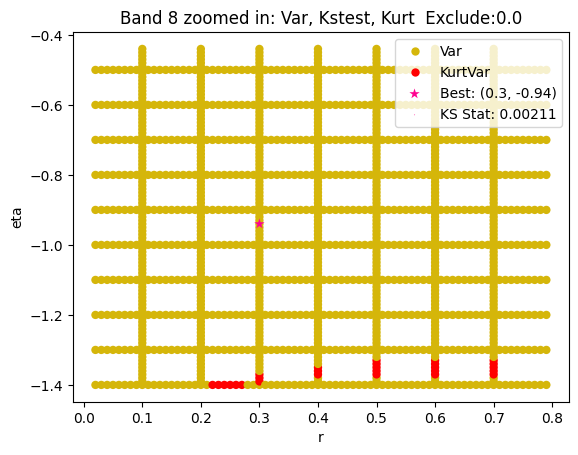

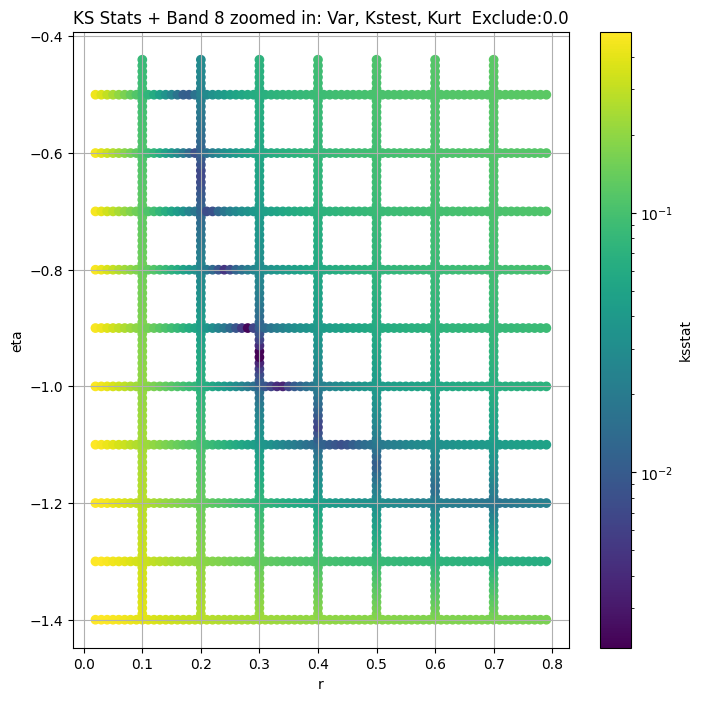

Band 9


  0%|          | 0/1485 [00:00<?, ?it/s]

Finding Minimum after computing 1485 CDFs
band 9, 25.0 + 100 = 125, ksstat: 0.004724085642792149, var: 0.031698439482416484


  0%|          | 0/1485 [00:00<?, ?it/s]

Finding Minimum after computing 1485 CDFs
band 9, 25.0 + 75 = 100, ksstat: 0.004434008941374301, var: 0.03236697326031578


  0%|          | 0/1485 [00:00<?, ?it/s]

Finding Minimum after computing 1485 CDFs
band 9, 25.0 + 50 = 75, ksstat: 0.004450959243018637, var: 0.033137307471927335


  0%|          | 0/1485 [00:00<?, ?it/s]

Finding Minimum after computing 1485 CDFs
band 9, 25.0 + 25 = 50, ksstat: 0.0039186435357334015, var: 0.03406186685523836


  0%|          | 0/1485 [00:00<?, ?it/s]

Finding Minimum after computing 1485 CDFs
band 9, 25.0 + 0 = 25, ksstat: 0.0044921492056932966, var: 0.03528077195112672


  0%|          | 0/1485 [00:00<?, ?it/s]

Finding Minimum after computing 1485 CDFs
band 9, 25.0 + -25 = 0, ksstat: 0.0032018373816724566, var: 0.037815678653209346
Number of samples: 100000, Without approximation : 5376893.0


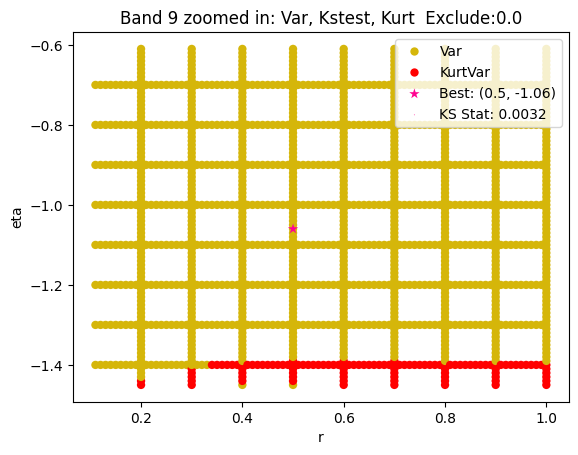

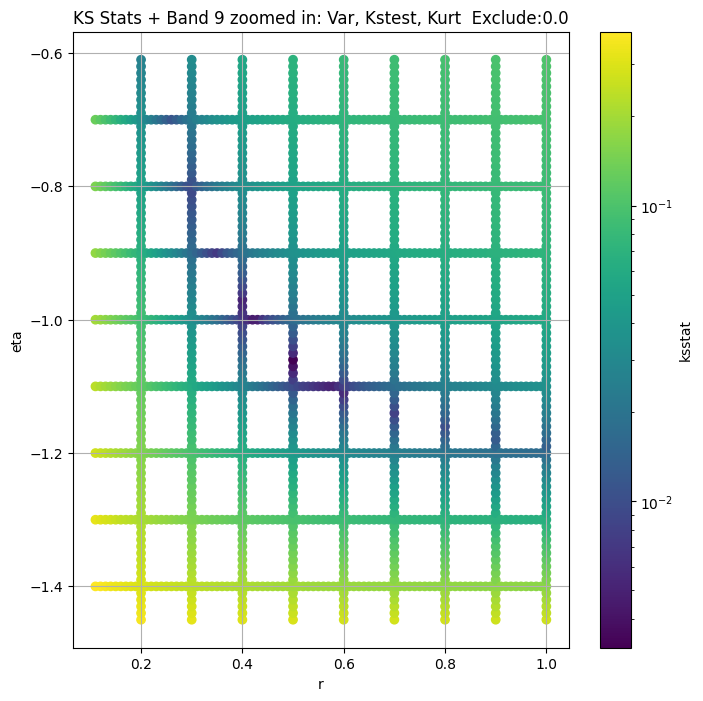

Band 11


  0%|          | 0/1320 [00:00<?, ?it/s]

Finding Minimum after computing 1320 CDFs
band 11, 150.0 + 100 = 250, ksstat: 0.007700391252008415, var: 0.010016235385457732


  0%|          | 0/1320 [00:00<?, ?it/s]

Finding Minimum after computing 1320 CDFs
band 11, 150.0 + 75 = 225, ksstat: 0.007192684116073433, var: 0.010340264628486069


  0%|          | 0/1320 [00:00<?, ?it/s]

Finding Minimum after computing 1320 CDFs
band 11, 150.0 + 50 = 200, ksstat: 0.007529927106506573, var: 0.010692502767010469


  0%|          | 0/1320 [00:00<?, ?it/s]

Finding Minimum after computing 1320 CDFs
band 11, 150.0 + 25 = 175, ksstat: 0.007053391045504953, var: 0.011078213190234063


  0%|          | 0/1320 [00:00<?, ?it/s]

Finding Minimum after computing 1320 CDFs
band 11, 150.0 + 0 = 150, ksstat: 0.006580785221715846, var: 0.011504407497533726


  0%|          | 0/1320 [00:00<?, ?it/s]

Finding Minimum after computing 1320 CDFs
band 11, 150.0 + -25 = 125, ksstat: 0.006653182325261825, var: 0.011980663500793213


  0%|          | 0/1320 [00:00<?, ?it/s]

Finding Minimum after computing 1320 CDFs
band 11, 150.0 + -50 = 100, ksstat: 0.005800983958151061, var: 0.012520898634945371


  0%|          | 0/1320 [00:00<?, ?it/s]

Finding Minimum after computing 1320 CDFs
band 11, 150.0 + -75 = 75, ksstat: 0.005587078747395745, var: 0.01314800038685783


  0%|          | 0/1320 [00:00<?, ?it/s]

Finding Minimum after computing 1320 CDFs
band 11, 150.0 + -100 = 50, ksstat: 0.005471309278126335, var: 0.013901440090807413
Number of samples: 100000, Without approximation : 6813712.0


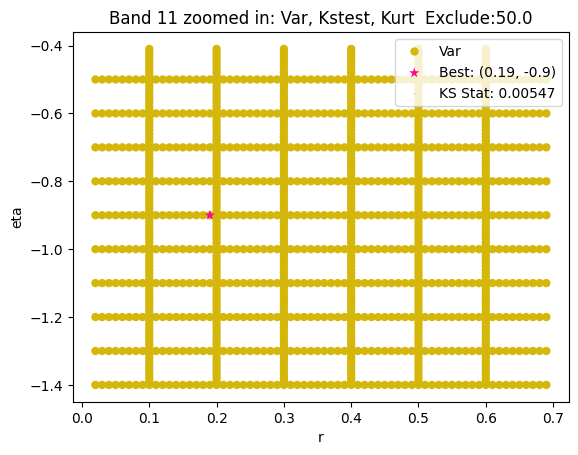

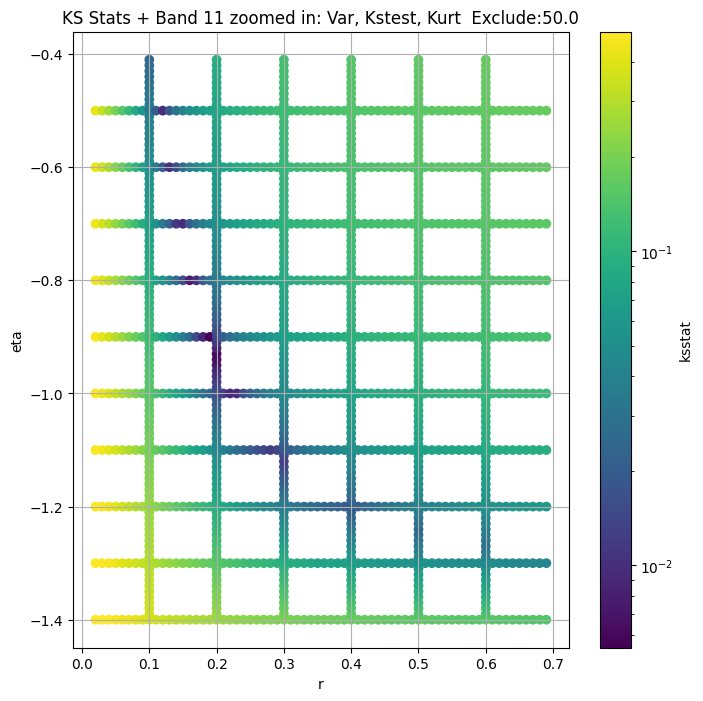

Band 12


  0%|          | 0/927 [00:00<?, ?it/s]

Finding Minimum after computing 927 CDFs
band 12, 100.0 + 100 = 200, ksstat: 0.006907748861618379, var: 0.0056927059659624395


  0%|          | 0/927 [00:00<?, ?it/s]

Finding Minimum after computing 927 CDFs
band 12, 100.0 + 75 = 175, ksstat: 0.007081803048117563, var: 0.005949406307641095


  0%|          | 0/927 [00:00<?, ?it/s]

Finding Minimum after computing 927 CDFs
band 12, 100.0 + 50 = 150, ksstat: 0.006489901951374732, var: 0.006233999046031464


  0%|          | 0/927 [00:00<?, ?it/s]

Finding Minimum after computing 927 CDFs
band 12, 100.0 + 25 = 125, ksstat: 0.005887144645468629, var: 0.0065534079346111634


  0%|          | 0/927 [00:00<?, ?it/s]

Finding Minimum after computing 927 CDFs
band 12, 100.0 + 0 = 100, ksstat: 0.0058260527508176025, var: 0.006917080760549033


  0%|          | 0/927 [00:00<?, ?it/s]

Finding Minimum after computing 927 CDFs
band 12, 100.0 + -25 = 75, ksstat: 0.005381916443523399, var: 0.007339761310532874


  0%|          | 0/927 [00:00<?, ?it/s]

Finding Minimum after computing 927 CDFs
band 12, 100.0 + -50 = 50, ksstat: 0.004905612222664946, var: 0.007848767501918692


  0%|          | 0/927 [00:00<?, ?it/s]

Finding Minimum after computing 927 CDFs
band 12, 100.0 + -75 = 25, ksstat: 0.005072560503467709, var: 0.008509341094612068


  0%|          | 0/927 [00:00<?, ?it/s]

Finding Minimum after computing 927 CDFs
band 12, 100.0 + -100 = 0, ksstat: 0.004691533255815616, var: 0.009694315800875913
Number of samples: 100000, Without approximation : 22438943.0


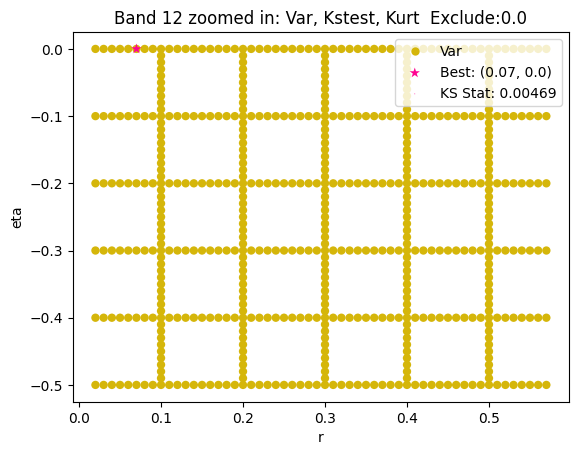

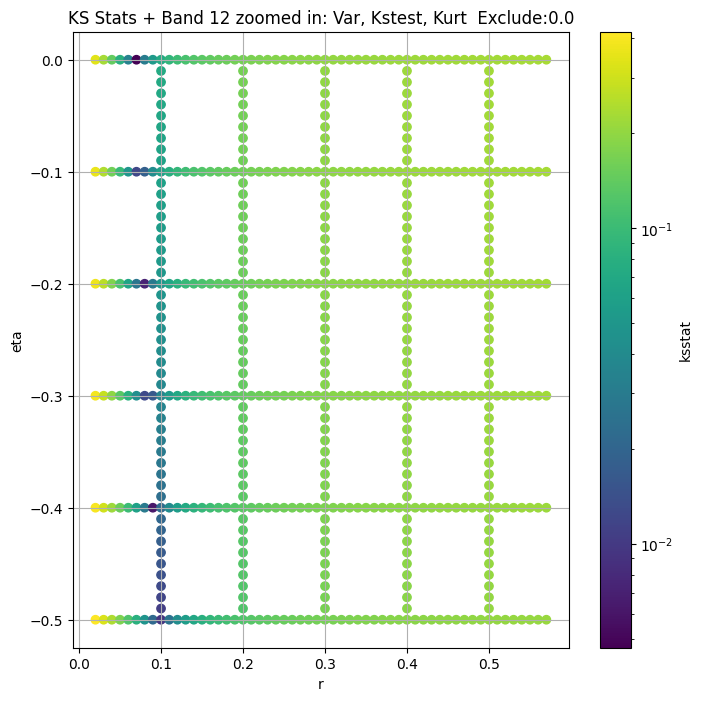

Band 14


  0%|          | 0/895 [00:00<?, ?it/s]

Finding Minimum after computing 895 CDFs
band 14, 150.0 + 100 = 250, ksstat: 0.007455154437758349, var: 0.00030046150530263716


  0%|          | 0/895 [00:00<?, ?it/s]

Finding Minimum after computing 895 CDFs
band 14, 150.0 + 75 = 225, ksstat: 0.006830383643584653, var: 0.0003122639168579942


  0%|          | 0/895 [00:00<?, ?it/s]

Finding Minimum after computing 895 CDFs
band 14, 150.0 + 50 = 200, ksstat: 0.006625566479234384, var: 0.00032513145088210497


  0%|          | 0/895 [00:00<?, ?it/s]

Finding Minimum after computing 895 CDFs
band 14, 150.0 + 25 = 175, ksstat: 0.006369206370457842, var: 0.00033923790249688505


  0%|          | 0/895 [00:00<?, ?it/s]

Finding Minimum after computing 895 CDFs
band 14, 150.0 + 0 = 150, ksstat: 0.006048563144146757, var: 0.00035485166428875665


  0%|          | 0/895 [00:00<?, ?it/s]

Finding Minimum after computing 895 CDFs
band 14, 150.0 + -25 = 125, ksstat: 0.00671508605583393, var: 0.00037238406419199267


  0%|          | 0/895 [00:00<?, ?it/s]

Finding Minimum after computing 895 CDFs
band 14, 150.0 + -50 = 100, ksstat: 0.007054972128161308, var: 0.00039236169153568866


  0%|          | 0/895 [00:00<?, ?it/s]

Finding Minimum after computing 895 CDFs
band 14, 150.0 + -75 = 75, ksstat: 0.006987349598846282, var: 0.00041560421367028126


  0%|          | 0/895 [00:00<?, ?it/s]

Finding Minimum after computing 895 CDFs
band 14, 150.0 + -100 = 50, ksstat: 0.009142933909353279, var: 0.00044381419370733815
Number of samples: 100000, Without approximation : 12633705.0


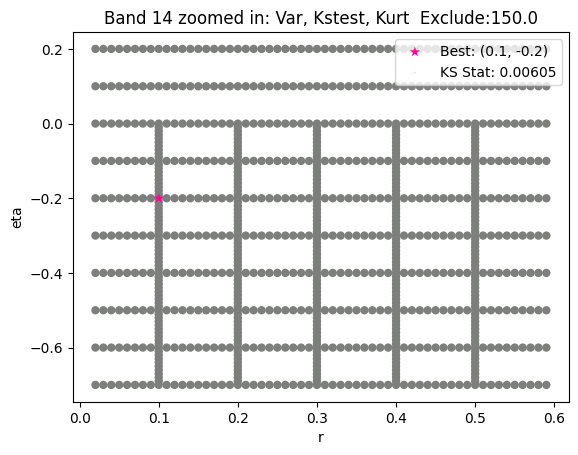

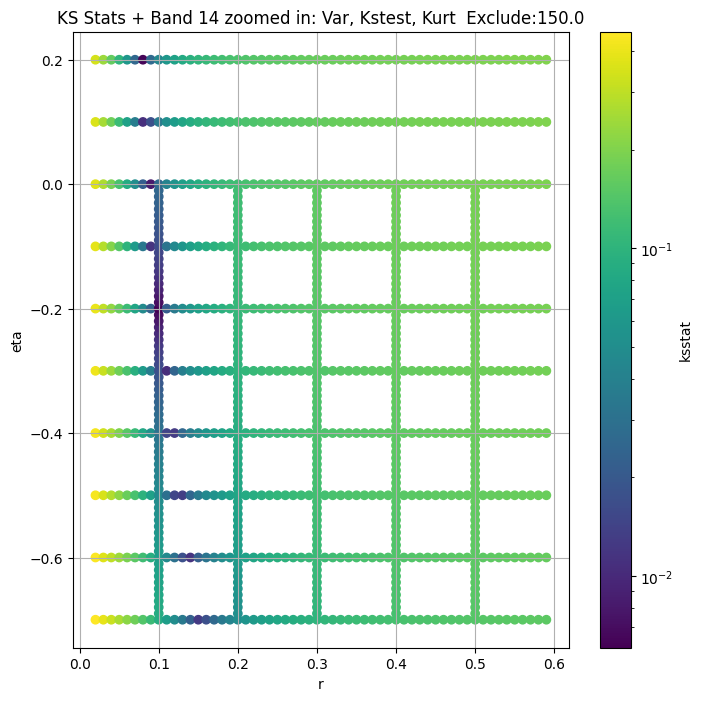

Band 16


  0%|          | 0/792 [00:00<?, ?it/s]

Finding Minimum after computing 792 CDFs
band 16, 500.0 + 100 = 600, ksstat: 0.009649769622772468, var: 1.7595947351168287e-05


  0%|          | 0/792 [00:00<?, ?it/s]

Finding Minimum after computing 792 CDFs
band 16, 500.0 + 75 = 575, ksstat: 0.009065239238033658, var: 1.8277027283687457e-05


  0%|          | 0/792 [00:00<?, ?it/s]

Finding Minimum after computing 792 CDFs
band 16, 500.0 + 50 = 550, ksstat: 0.00900645768563424, var: 1.9009965627271733e-05


  0%|          | 0/792 [00:00<?, ?it/s]

Finding Minimum after computing 792 CDFs
band 16, 500.0 + 25 = 525, ksstat: 0.008671640639095425, var: 1.980135798622015e-05


  0%|          | 0/792 [00:00<?, ?it/s]

Finding Minimum after computing 792 CDFs
band 16, 500.0 + 0 = 500, ksstat: 0.008467320925393285, var: 2.0657479649819092e-05


  0%|          | 0/792 [00:00<?, ?it/s]

Finding Minimum after computing 792 CDFs
band 16, 500.0 + -25 = 475, ksstat: 0.00808029072937735, var: 2.158545039399684e-05


  0%|          | 0/792 [00:00<?, ?it/s]

Finding Minimum after computing 792 CDFs
band 16, 500.0 + -50 = 450, ksstat: 0.007771056007479571, var: 2.2596572705634373e-05


  0%|          | 0/792 [00:00<?, ?it/s]

Finding Minimum after computing 792 CDFs
band 16, 500.0 + -75 = 425, ksstat: 0.00804993921852265, var: 2.3698221275770174e-05


  0%|          | 0/792 [00:00<?, ?it/s]

Finding Minimum after computing 792 CDFs
band 16, 500.0 + -100 = 400, ksstat: 0.007222540872677685, var: 2.4903527643446268e-05
Number of samples: 100000, Without approximation : 8261428.0


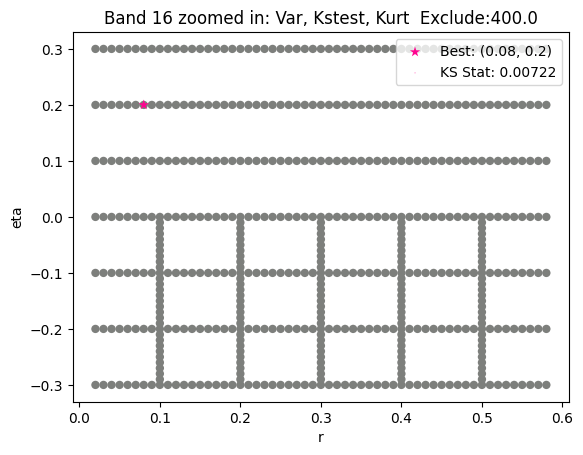

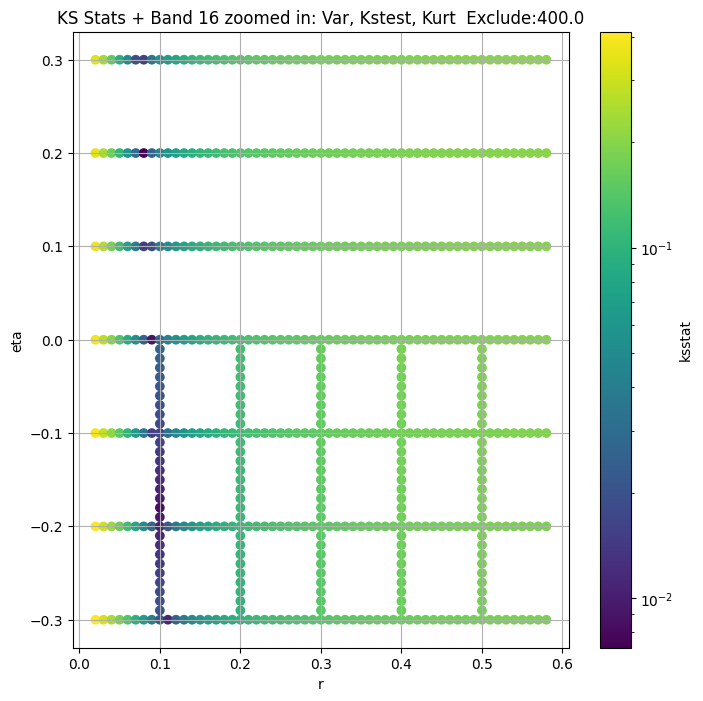

obs_var  var_lower  var_upper    obs_kurt  kurt_lower  kurt_upper  \
band                                                                       
2     0.006331   0.005661   0.007222   20.091526    8.301169   54.159079   
3     0.003786   0.003245   0.004591   45.824363   12.004293  112.151525   
5     2.128757   1.943052   2.320288    9.899200    8.736989   11.148364   
6     1.585753   1.449861   1.725575    9.456193    8.451809   10.508710   
8     0.193077   0.167066   0.222789   29.596515   20.241751   40.285456   
9     0.037816   0.033569   0.043264   21.922664   10.518936   59.659771   
11    0.016603   0.013695   0.020071   52.159590   32.308096   94.441255   
12    0.009694   0.007775   0.012055   70.446049   43.759223  129.165796   
14    0.000566   0.000441   0.000798  135.246009   42.063264  480.972013   
16    0.000128   0.000083   0.000198  298.160503  115.687456  695.444976   

      total_samples  kstest_stat_initial  initial_r  initial_eta  \
band                                                               
2           99231.0             0.001576        0.5         -0.9   
3          110499.0             0.003377        0.2         -0.2   
5         1094491.0             0.016259        0.4         -1.2   
6          552872.0             0.012242        0.4         -1.1   
8         3583528.0             0.003957        0.3         -0.9   
9         5376893.0             0.004983        0.6         -1.1   
11        6813712.0             0.007415        0.2         -0.9   
12       22438943.0             0.005910        0.1         -0.4   
14       12633705.0             0.006049        0.1         -0.2   
16        8261428.0             0.008558        0.1         -0.1   

      initial_scale  initial_exclude_cutoff  best_augmented_var  \
band                                                              
2      2.398058e-03                     0.0            0.006331   
3      9.158696e-08                     0.0            0.003394   
5      1.023284e+00                     0.0            2.128757   
6      4.424368e-01                   100.0            1.585753   
8      4.223364e-03                    50.0            0.193077   
9      4.012493e-02                    25.0            0.037816   
11     4.565241e-06                   150.0            0.013901   
12     1.031719e-14                   100.0            0.009694   
14     1.512228e-16                   150.0            0.000355   
16     4.975804e-18                   500.0            0.000025   

      kstest_stat_cutoff_0.05  kstest_stat_best  best_r  best_eta  \
band                                                                
2                    0.004310          0.001576    0.50     -0.90   
3                    0.004084          0.001328    0.31     -0.60   
5                    0.001298          0.013492    0.43     -1.20   
6                    0.001826          0.010499    0.40     -1.12   
8                    0.000717          0.002110    0.30     -0.94   
9                    0.000586          0.003202    0.50     -1.06   
11                   0.000520          0.005471    0.19     -0.90   
12                   0.000287          0.004692    0.07      0.00   
14                   0.000382          0.006049    0.10     -0.20   
16                   0.000472          0.007223    0.08      0.20   

        best_scale  best_exclude_cutoff  n_pval_0.05  
band                                                  
2     2.398058e-03                  0.0       753531  
3     4.153196e-05                 25.0      1061982  
5     1.355996e+00                  0.0         9618  
6     5.198564e-01                  0.0        17277  
8     5.634877e-03                  0.0       425191  
9     2.285764e-02                  0.0       189030  
11    2.712804e-06                 50.0        59886  
12    2.317210e-23                  0.0        87652  
14    1.512228e-16                150.0        49350  
16    3.574106e-23                400.

In [15]:
master_df_optimized_path = Path(os.path.join(CWD, "CSVs", 'master_df_optimized.csv'))

NUM_ITERS = dict(zip(GROUPS, [1]*len(GROUPS))) # By default, does one iteration per group
NUM_SAMPLES_OPTIMIZE = 2000
EXCLUDE_CUTOFFS_OPTIMIZE = np.arange(100, -101, -25)

if RERUN or not master_df_optimized_path.exists():

    if SKIP_OPTIMIZE_STEP:

        master_df['kstest_stat_best'] = master_df['kstest_stat_initial']
        master_df[f'best_r'] = master_df['initial_r']
        master_df[f'best_eta'] = master_df['initial_eta']
        master_df[f'best_scale'] = master_df['initial_scale']
        master_df[f'best_exclude_cutoff'] = master_df['initial_exclude_cutoff']

    else:
        for group in GROUPS: # TODO For quick testing purposes
            print(f"{GROUP.capitalize()} {group}")
            master_df.loc[group, 'kstest_stat_best'] = master_df.loc[group, 'kstest_stat_initial']
            master_df.loc[group, 'best_r'] = master_df.loc[group, 'initial_r']
            master_df.loc[group, 'best_eta'] = master_df.loc[group, 'initial_eta']
            master_df.loc[group, 'best_scale'] = master_df.loc[group, 'initial_scale']

            sample = group_data_map[group]
            if len(sample) == 0:
                continue
            initial_r, initial_eta = master_df.loc[group, 'initial_r'], master_df.loc[group, f'initial_eta']
            eps = 0.5
            group_cdfs_df = fine_cdfs_df[(np.abs(master_df.loc[group, 'initial_r'] - fine_cdfs_df['r']) < eps) & 
                                        (np.abs(master_df.loc[group, 'initial_eta'] - fine_cdfs_df['eta']) < eps)].reset_index(drop=True)
            group_cdfs = {x[0]:x[1] for x in group_cdfs_df['(r,eta),cdf']}

            for adjust_exclude_cutoff in EXCLUDE_CUTOFFS_OPTIMIZE: # -50, -25, 0, 25, 50
                
                exclude_cutoff = int(max(0, adjust_exclude_cutoff + master_df.loc[group, 'initial_exclude_cutoff']))
                
                if exclude_cutoff == 0:
                    augmented_var = np.var(group_data_map[group])
                else:
                    augmented_var = np.var(group_data_map[group][exclude_cutoff:-exclude_cutoff])                       

                group_cdfs_df['scale'] = np.clip((augmented_var / group_cdfs_df['variance']), 0,  SCALE_CAP)
                ksstats, initial_param, min_stat = gridsearch(sample, group_cdfs, debug=True, scales=group_cdfs_df['scale'])
                
                cutoff_label = generate_cutoff_label(adjust_exclude_cutoff)

                augmented_var_df.loc[group, f"kstest_stat_{cutoff_label}"] = min_stat
                group_cdfs_df[f'ksstat_exclude_{cutoff_label}'] = ksstats
                
                print(f"{GROUP} {group}, {master_df.loc[group, 'initial_exclude_cutoff']} + {adjust_exclude_cutoff} = {exclude_cutoff}, ksstat: {min_stat}, var: {augmented_var}")
                best_adjust = 0

                if min_stat < master_df.loc[group, 'kstest_stat_best']:

                    inital_min_stat = min_stat
                    inital_best_param = initial_param
                    master_df.loc[group, 'kstest_stat_best'] = min_stat
                    initial_scale = group_cdfs_df.loc[(group_cdfs_df["r"] ==  initial_param[0]) & (group_cdfs_df["eta"] ==  initial_param[1])]["scale"].iloc[0]
                    master_df.loc[group, 'best_r'], master_df.loc[group, 'best_eta'] = initial_param
                    master_df.loc[group, 'best_scale'] = initial_scale
                    master_df.loc[group, 'best_exclude_cutoff'] = exclude_cutoff
                    master_df.loc[group, 'best_augmented_var'] = augmented_var
                    augmented_var_df.loc[group, 'best_augmented_var'] = augmented_var
                    best_adjust = adjust_exclude_cutoff

                if exclude_cutoff == 0:
                    break

            cutoff_label = generate_cutoff_label(best_adjust)
            ksstats = group_cdfs_df[f"ksstat_exclude_{cutoff_label}"]
            
            print(f"Number of samples: {sample.size}, Without approximation : {master_df.loc[group, 'total_samples']}")
            
            cutoff = stats.kstwo(n=master_df.loc[group, 'total_samples']).isf(0.05)
            master_df.loc[group, 'kstest_stat_cutoff_0.05'] = cutoff

            best_scales = np.clip((master_df.loc[group, 'best_augmented_var'] / group_cdfs_df['variance']), 0,  SCALE_CAP)

            group_cdfs_df['variance'] = group_cdfs_df['variance'] * best_scales
            group_cdfs_df['kurtosis'] = group_cdfs_df['kurtosis'] * best_scales

            group_cdfs_df = add_tests_to_df(cdfs_df = group_cdfs_df, group = group, var_kurt_df = master_df, ksstats = ksstats).sort_values(['r', 'eta'])

            group_dict = rEtaKsstats_dict[group]
            group_dict.update({'r_optimize' : group_cdfs_df['r'], 'eta_optimize' : group_cdfs_df['eta'], f'ksstat_exclude_{cutoff_label}' : ksstats})
            rEtaKsstats_dict[group] = group_dict

            cols = ['pass_var', 'pass_kstest', 'pass_kurt']
            fig = combo_test_plot(group_cdfs_df, cols, 
                                plot_name=f"{GROUP.capitalize()} {group} zoomed in: {', '.join([col[5:].capitalize() for col in cols])}  Exclude:{master_df.loc[group, 'best_exclude_cutoff']}",
                                best_param=(master_df.loc[group, 'best_r'], master_df.loc[group, f'best_eta']),
                                best_ksstat=master_df.loc[group, 'kstest_stat_best'])
            fig.figure.savefig(os.path.join(CWD, "plots", f"optimized_full_grid_search_combo_plot_layer{group}.jpg"), bbox_inches = 'tight', dpi=100)
            
    master_df['n_pval_0.05'] = master_df.apply(lambda row : find_n_fixed_pval_stat(row.loc['kstest_stat_best'], row.loc['total_samples']), axis = 1)    
    master_df[['total_samples', 'initial_r', 'initial_eta', 'kstest_stat_initial', 'initial_exclude_cutoff', 'best_r', 'best_eta', 'best_scale', 'kstest_stat_best', 'best_exclude_cutoff', 'n_pval_0.05']].to_csv(os.path.join(CWD, "CSVs", 'optimized_params.csv'))
    master_df.to_csv(os.path.join(CWD, "CSVs", 'master_df_optimized.csv'))
    augmented_var_df.to_csv(augmented_var_df_path)
    pd.to_pickle(rEtaKsstats_dict, rEtaKsstats_dict_path)

rEtaKsstats_dict = pd.read_pickle(rEtaKsstats_dict_path)
master_df = pd.read_csv(master_df_optimized_path, index_col = GROUP)
augmented_var_df = pd.read_csv(augmented_var_df_path, index_col = GROUP)
master_df

## Comparing Empirical and Computed CDF/PDF

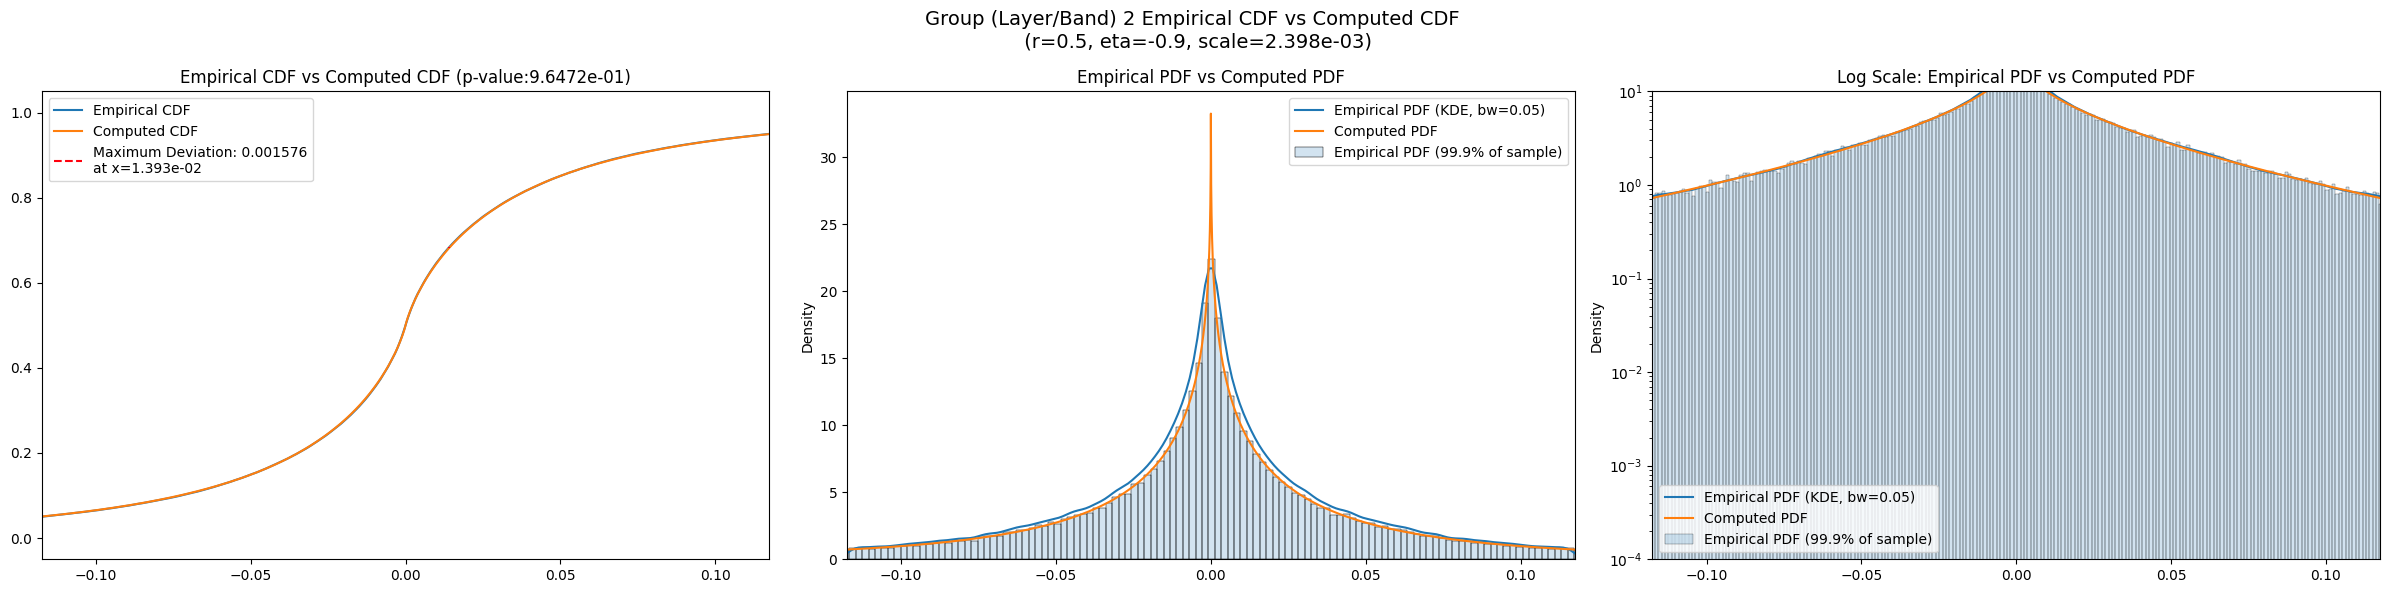

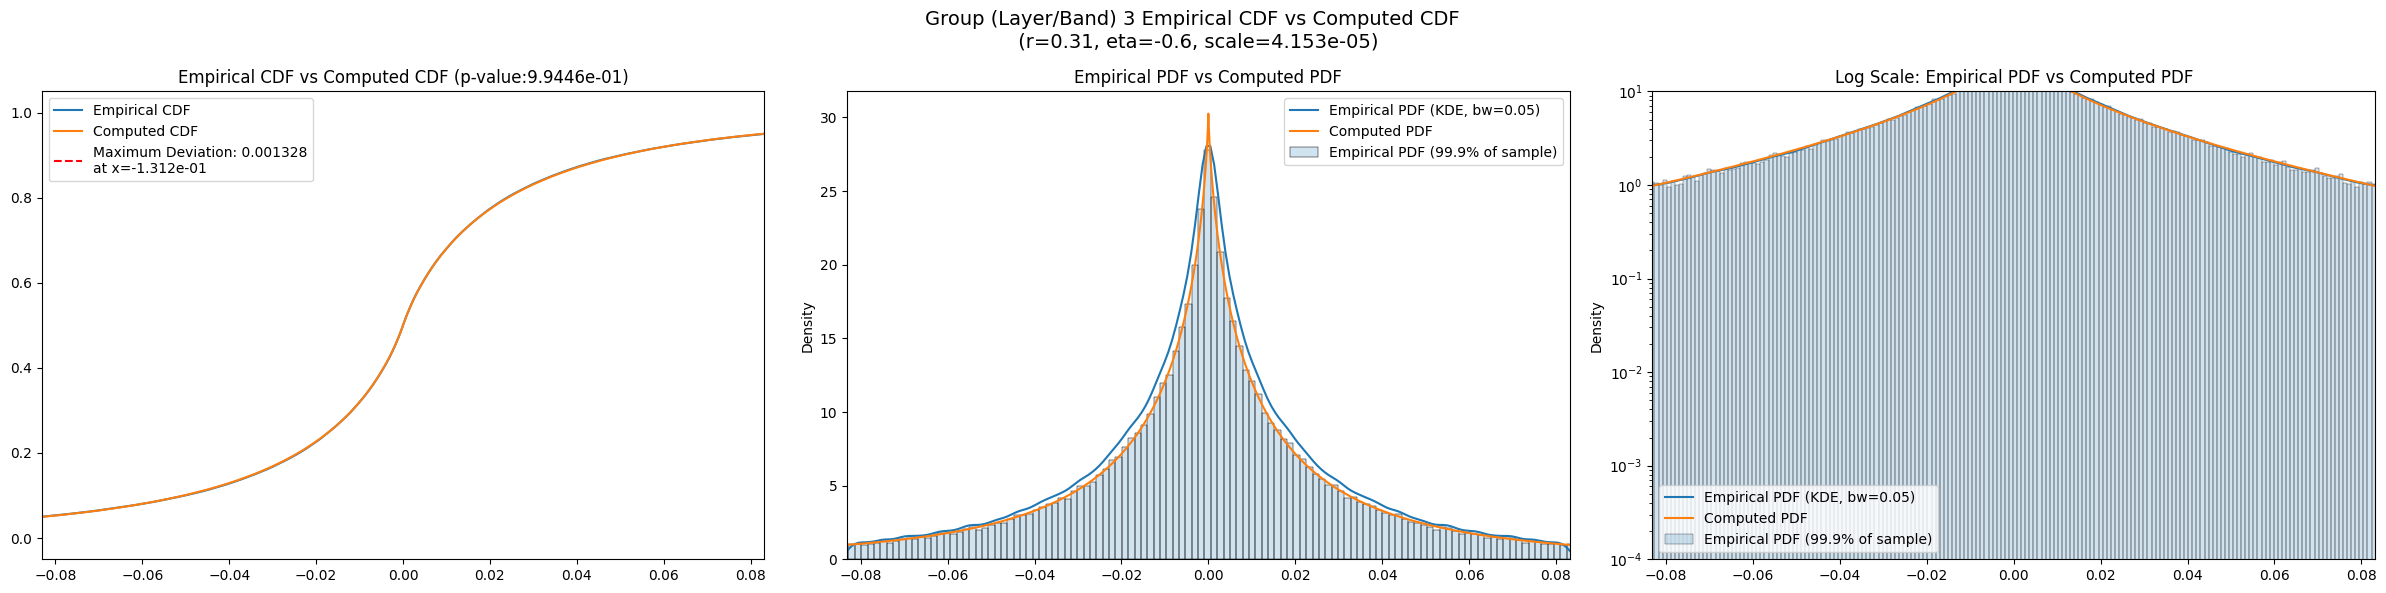

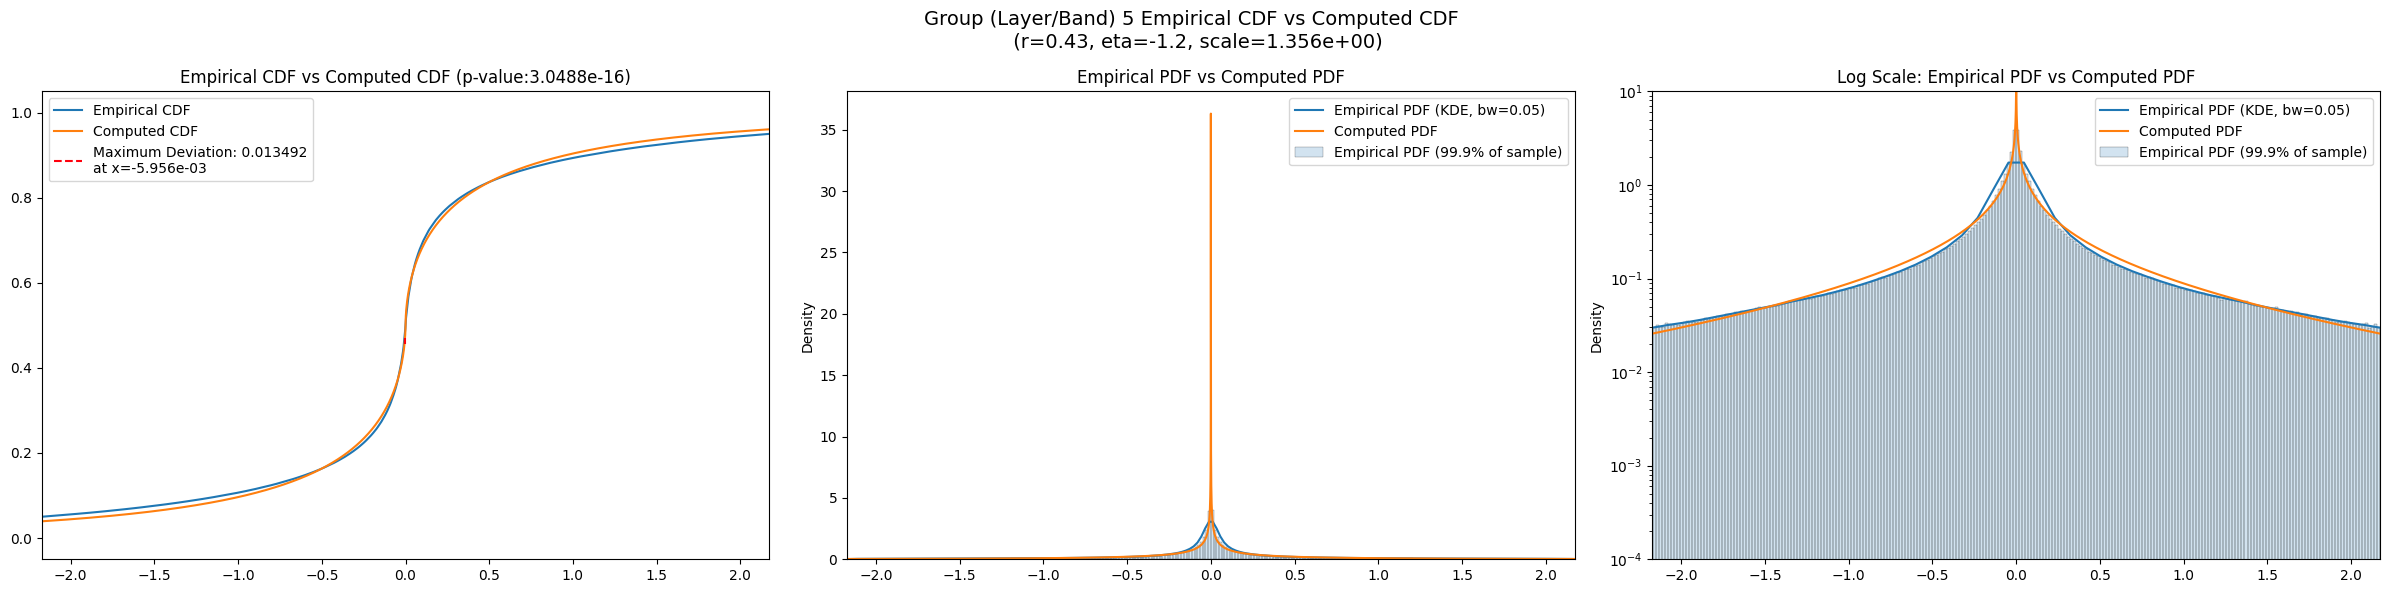

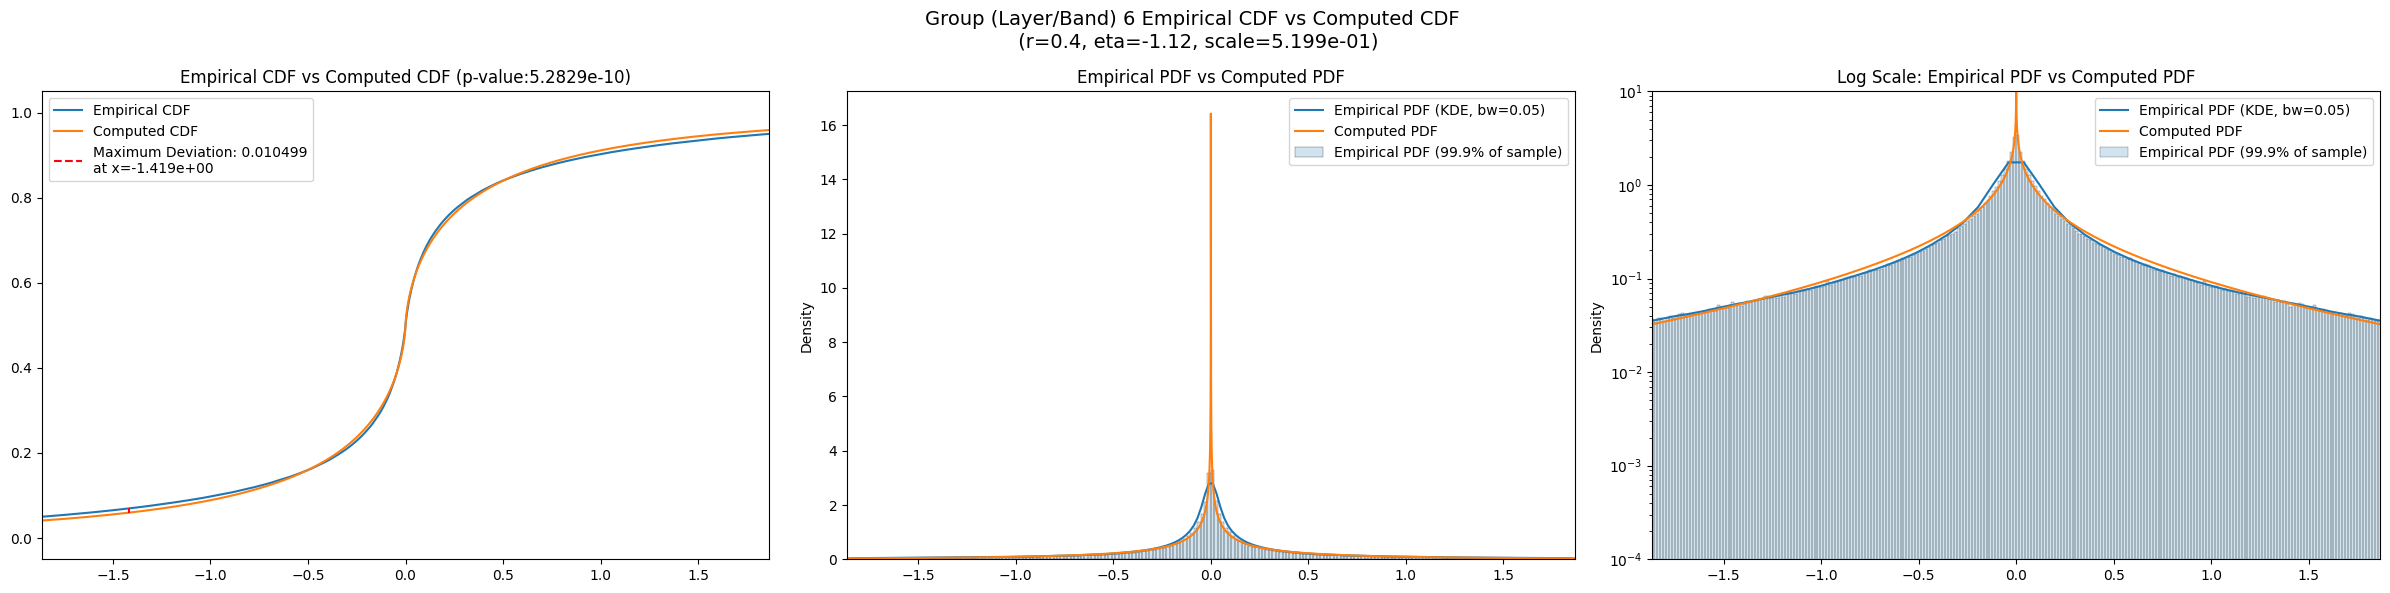

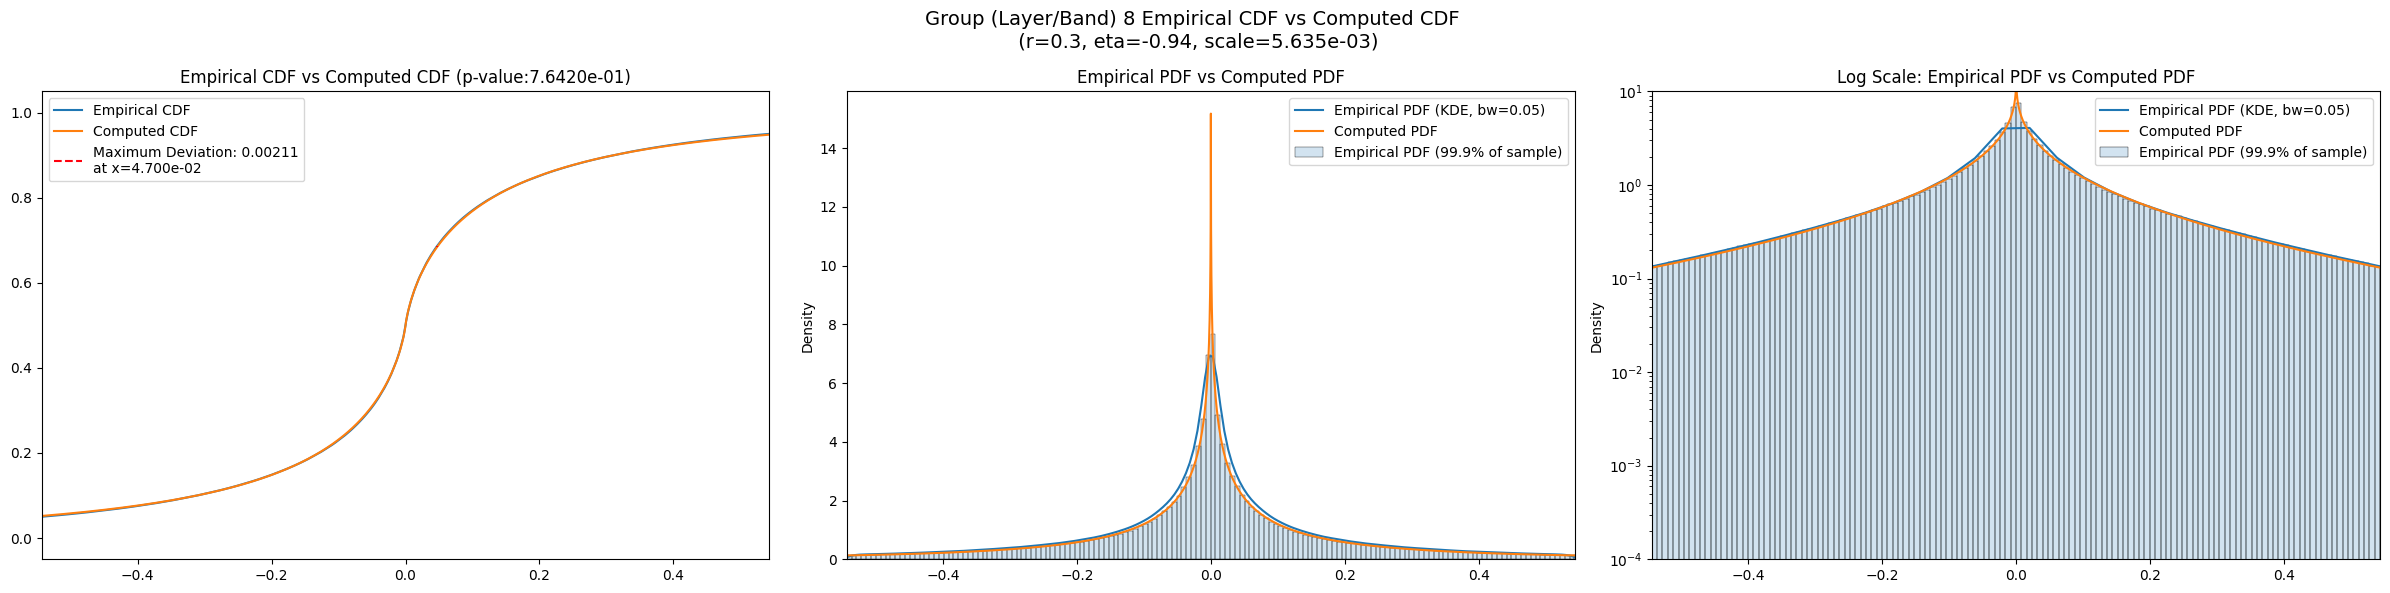

C:\Users\Henry\AppData\Roaming\Python\Python311\site-packages\IPython\core\pylabtools.py:170: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


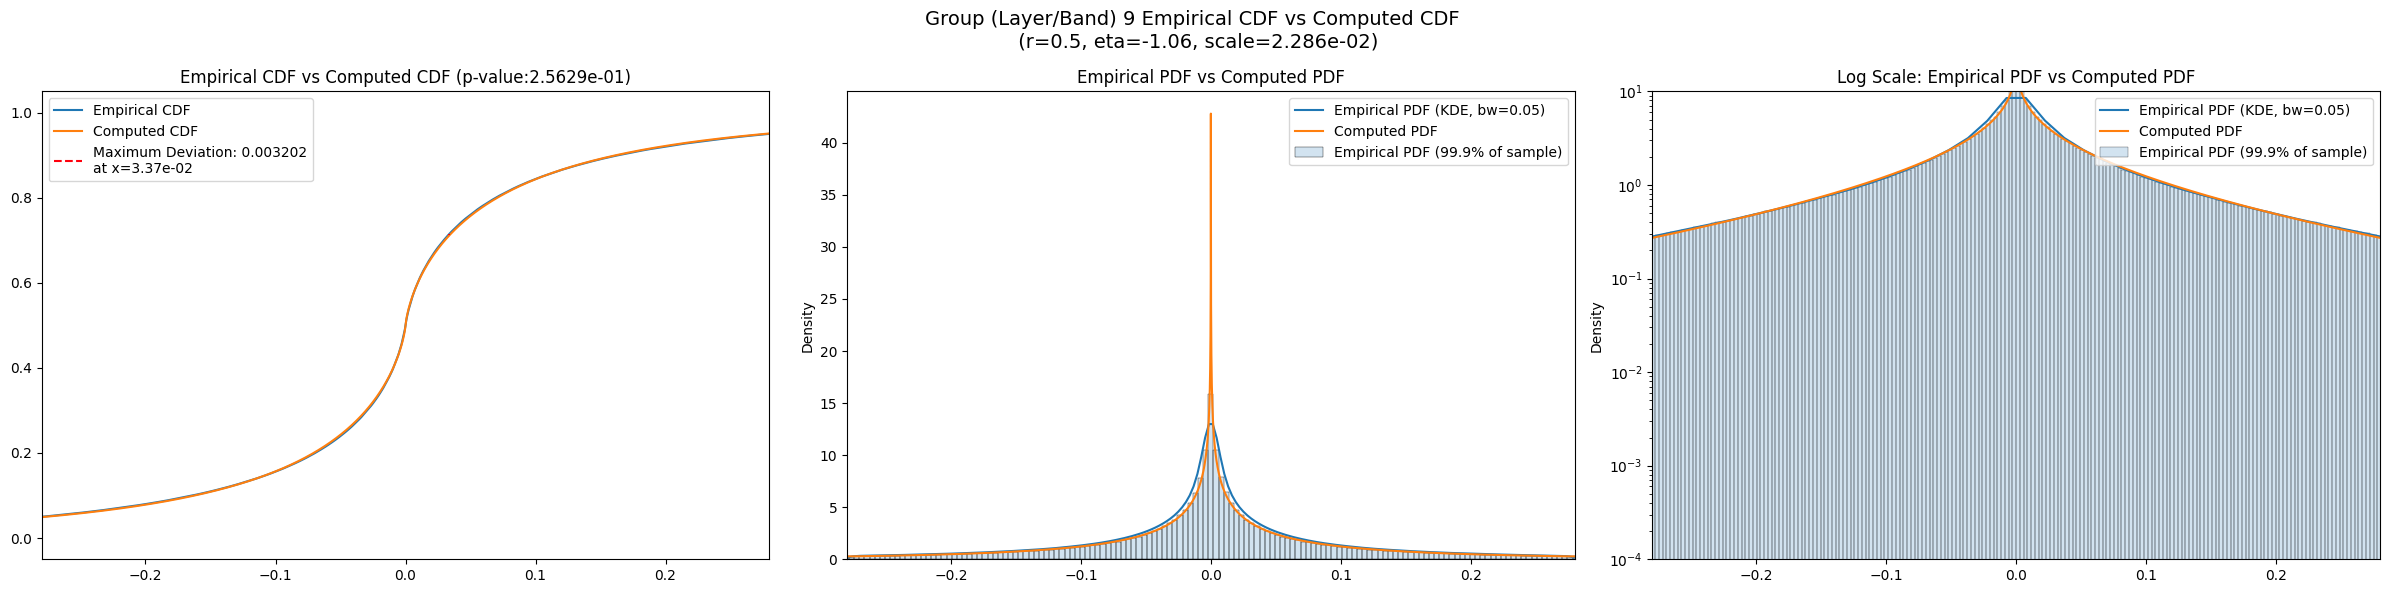

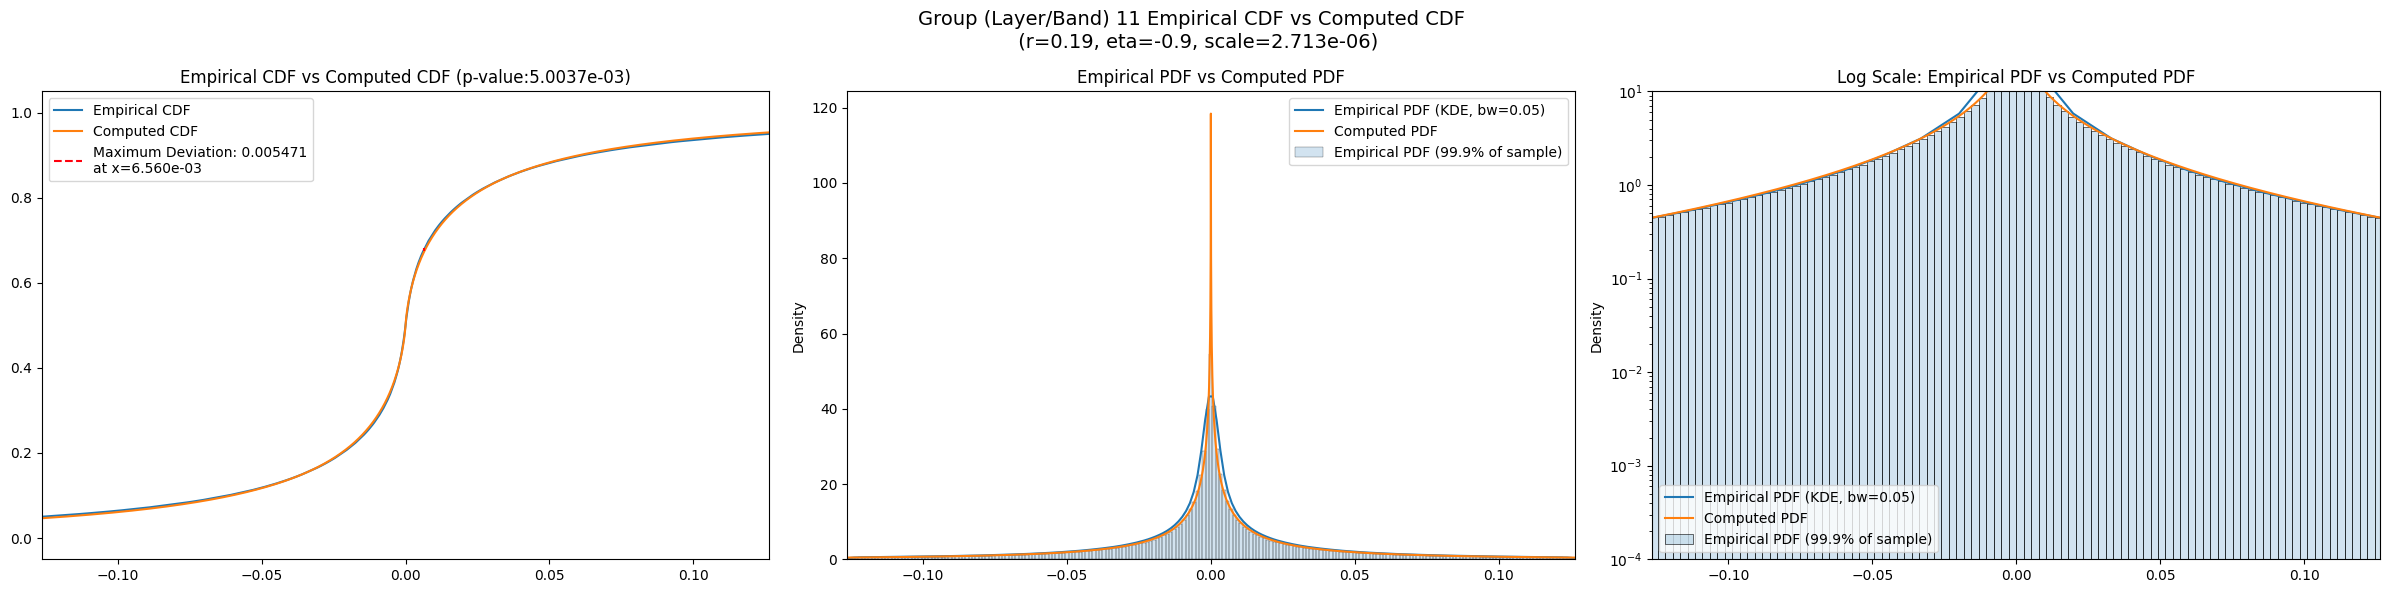

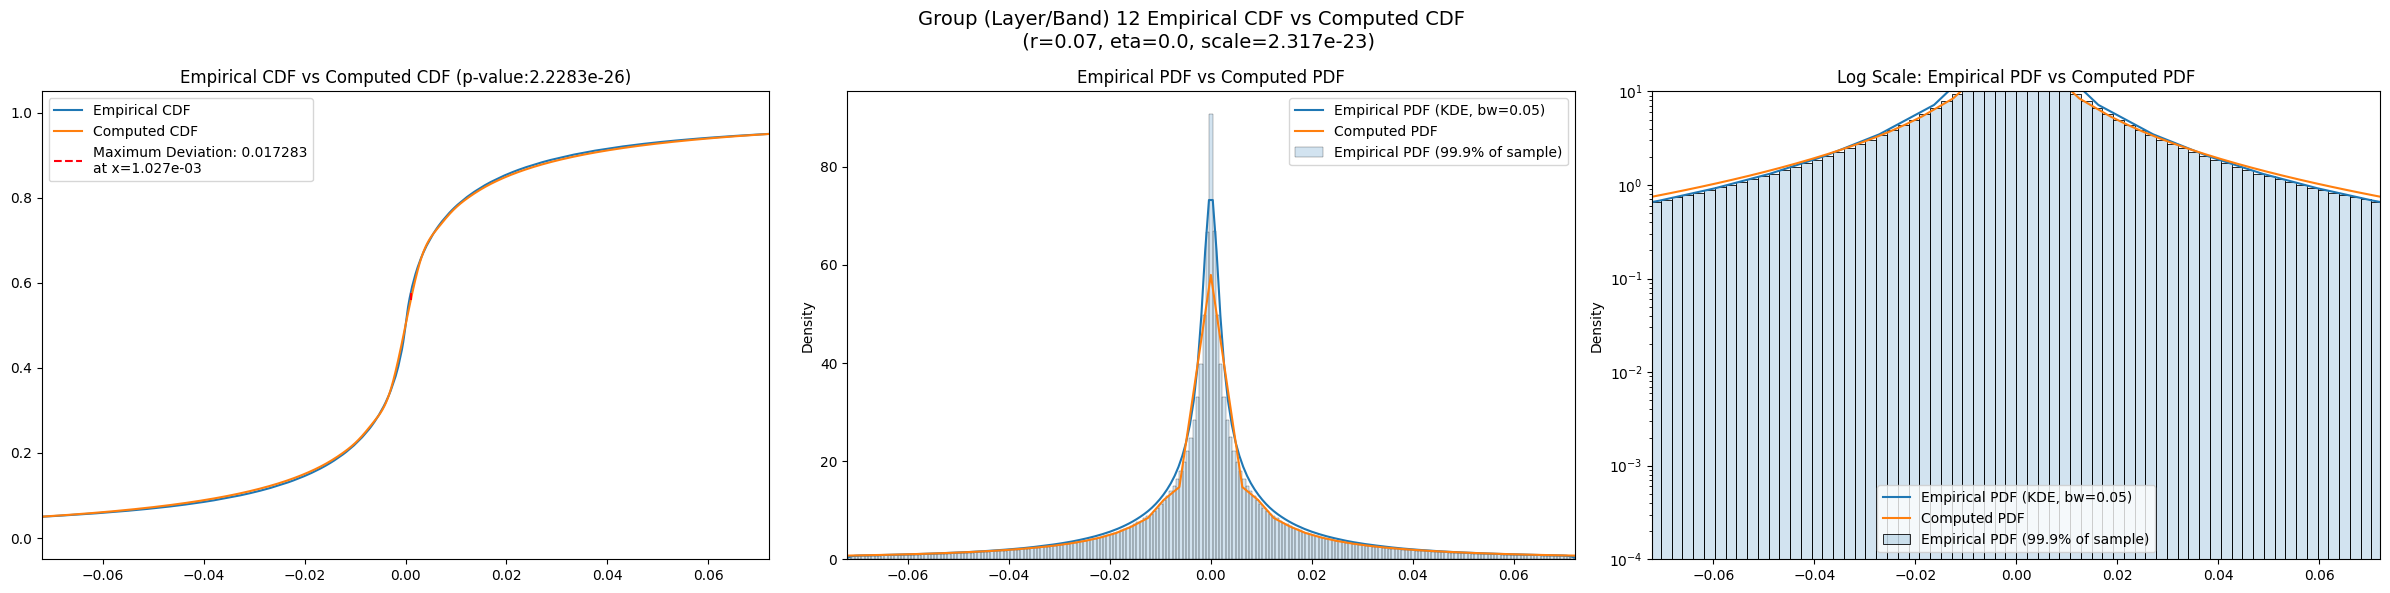

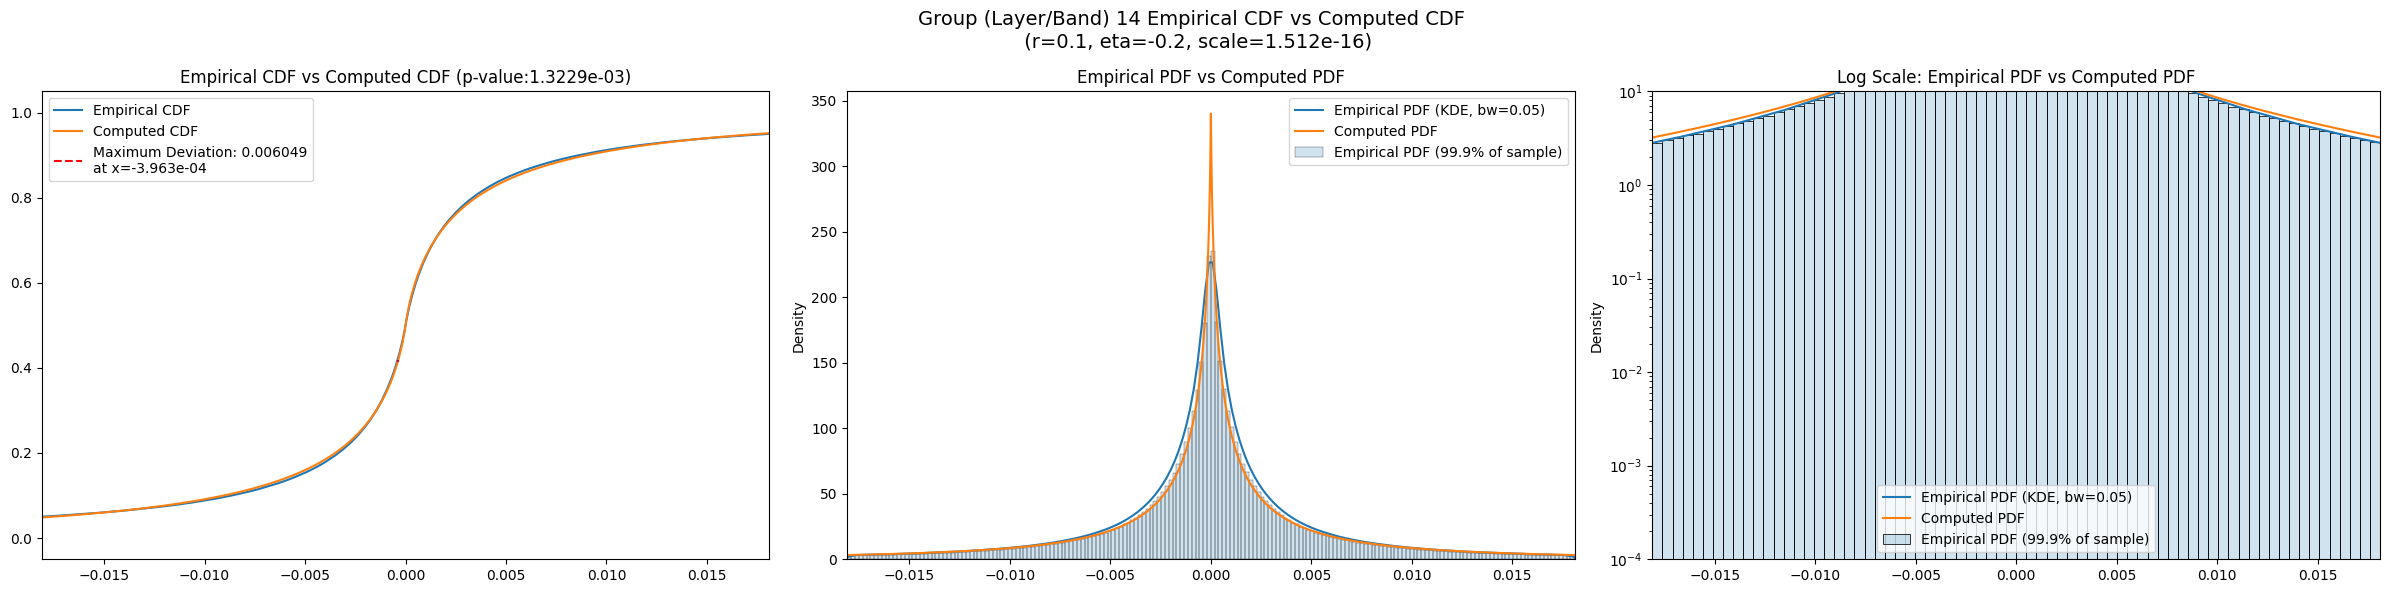

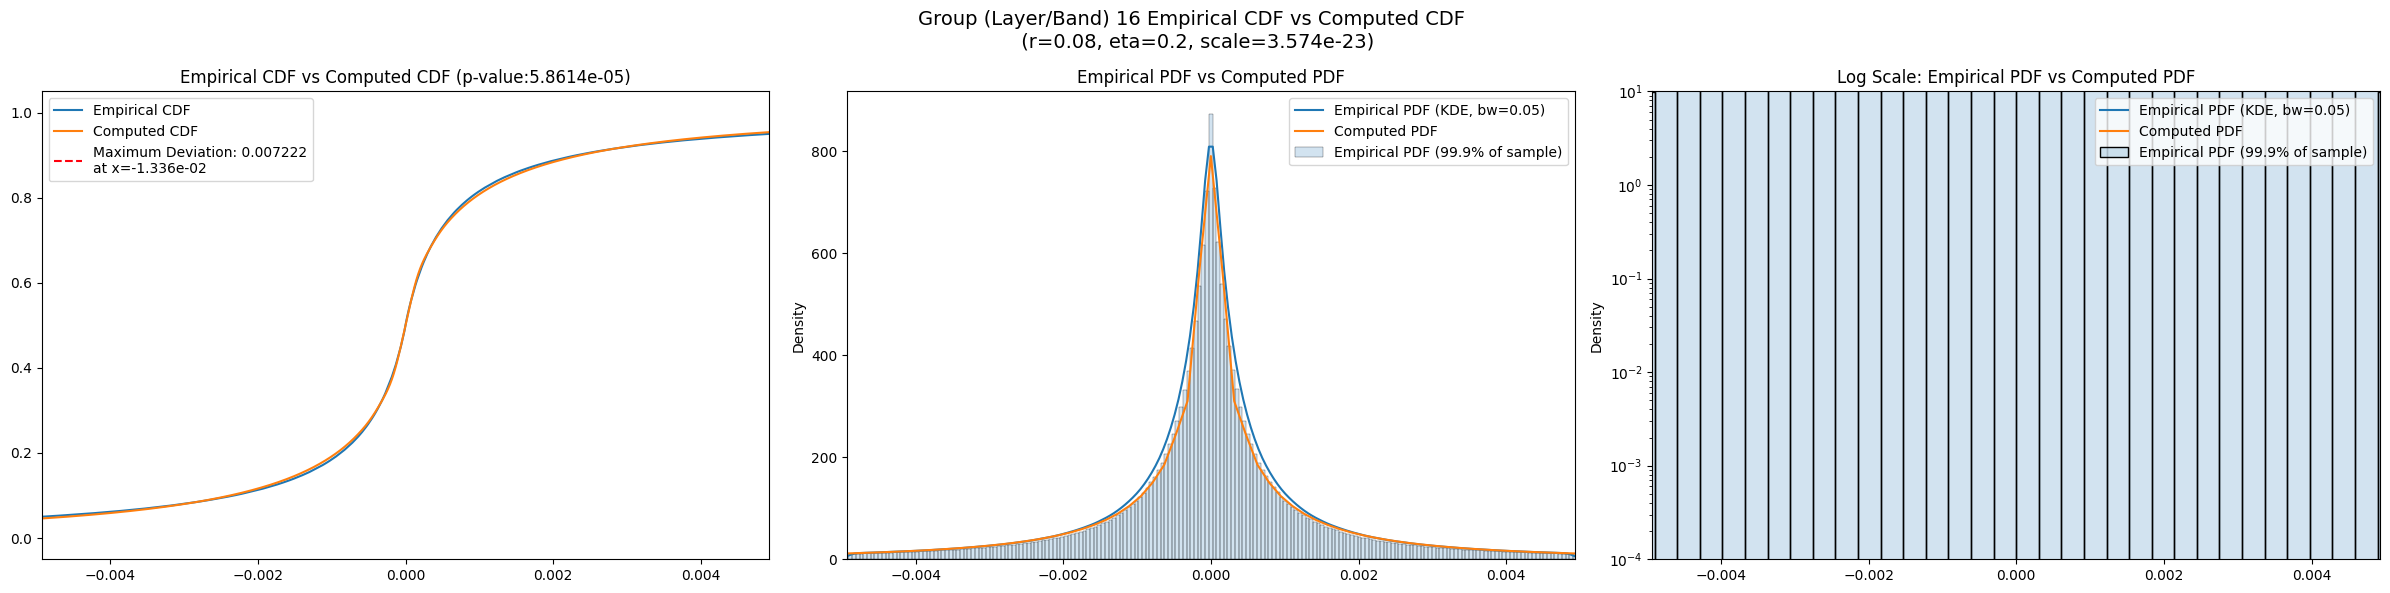

In [16]:
for group in GROUPS:
    group_info = master_df.loc[group]
    best_r = group_info['best_r']
    best_eta = group_info['best_eta']
    best_scale = group_info['best_scale']
    fig = visualize_cdf_pdf(sample = group_data_map[group], 
                    params = (best_r, best_eta, best_scale), 
                    log_scale = True,
                    group = group)
    fig.savefig(os.path.join(CWD, "plots", f'compare_cdf_pdf_layer_{group}.jpg'), bbox_inches = 'tight', dpi = 100)

## Comparing with Gaussian and Laplace Priors

In [17]:
def generate_func(sample, distro, *args, n_samples=200):
    if distro == 'gaussian' or distro == 'normal':
        def var_func(var):
            cdf = scipy.stats.norm(scale=var).cdf
            return compute_ksstat(sample, cdf)
        return var_func
    elif distro == 'laplace':
        def var_func(var):
            cdf = scipy.stats.laplace(scale=var).cdf
            return compute_ksstat(sample, cdf)
        return var_func
    elif distro == 't':
        def var_func(var):
            cdf = scipy.stats.t(df=2, scale=var).cdf
            return compute_ksstat(sample, cdf)
        return var_func
    elif distro == 'prior_r':
        eta = args[0]
        def r_func(r):
            cdf = compute_prior_cdf(r, eta, n_samples=n_samples)
            return compute_ksstat(sample, cdf)
        return r_func
    elif distro == 'prior_eta':
        r = args[0]
        def eta_func(eta):
            cdf = compute_prior_cdf(r, eta, n_samples=n_samples)
            return compute_ksstat(sample, cdf)
        return eta_func
    elif distro == 'prior':
        def r_eta_func(params):
            r = params[0]
            eta = params[1]
            cdf = compute_prior_cdf(r, eta, n_samples=n_samples, debug=False)
            return compute_ksstat(sample, cdf)
        return r_eta_func
    elif distro == 'prior_with_scale':
        def r_eta_scale_func(params):
            r = params[0]
            eta = params[1]
            scale = params[2]
            print(r, eta, scale)
            cdf = compute_prior_cdf(r = r, eta = eta, n_samples=n_samples, debug=False)
            return compute_ksstat(sample/ np.sqrt(scale), cdf)
        return r_eta_scale_func

    print("Please enter a valid argument for `distro`: 'gaussian', 'laplace', 'prior_r', 'prior_eta', 'prior','prior_with_scale', 't'")

In [18]:
master_df_path = Path(os.path.join(CWD, "CSVs", 'master_df.csv'))

if RERUN or not master_df_path.exists():
    upper_bound = int(1e6)
    for group in GROUPS:
        if len(group_data_map[group]) == 0:
            continue
        norm_result = scipy.optimize.minimize_scalar(generate_func(group_data_map[group], 'gaussian'), method = 'bounded', bounds = (0, upper_bound))
        laplace_result = scipy.optimize.minimize_scalar(generate_func(group_data_map[group], 'laplace'), method = 'bounded', bounds = (0, upper_bound))
        t_result = scipy.optimize.minimize_scalar(generate_func(group_data_map[group], 't'), method = 'bounded', bounds = (0, upper_bound))
        
        master_df.loc[group, 'param_gaussian'] = round_to_sigfigs(norm_result['x'], 6)
        master_df.loc[group, 'kstest_stat_gaussian'] = round_to_sigfigs(norm_result['fun'], 6)
        master_df.loc[group, 'kstest_pval_gaussian'] = round_to_sigfigs(stats.kstwo(n=master_df.loc[group, 'total_samples']).sf(master_df.loc[group, 'kstest_stat_gaussian']), 6)

        master_df.loc[group, 'param_laplace'] = round_to_sigfigs(laplace_result['x'], 6)
        master_df.loc[group, 'kstest_stat_laplace'] = round_to_sigfigs(laplace_result['fun'], 6)
        master_df.loc[group, 'kstest_pval_laplace'] = round_to_sigfigs(stats.kstwo(n=master_df.loc[group, 'total_samples']).sf(master_df.loc[group, 'kstest_stat_laplace']), 6)

        master_df.loc[group, 'param_laplace'] = round_to_sigfigs(laplace_result['x'], 6)
        master_df.loc[group, 'kstest_stat_laplace'] = round_to_sigfigs(laplace_result['fun'], 6)
        master_df.loc[group, 'kstest_pval_laplace'] = round_to_sigfigs(stats.kstwo(n=master_df.loc[group, 'total_samples']).sf(master_df.loc[group, 'kstest_stat_laplace']), 6) 

        master_df.loc[group, 'param_t'] = round_to_sigfigs(t_result['x'], 6)
        master_df.loc[group, 'kstest_stat_t'] = round_to_sigfigs(t_result['fun'], 6)
        master_df.loc[group, 'kstest_pval_t'] = round_to_sigfigs(stats.kstwo(n=master_df.loc[group, 'total_samples']).sf(master_df.loc[group, 'kstest_stat_t']), 6) 

        master_df.loc[group, 'kstest_pval_gengamma'] = round_to_sigfigs(stats.kstwo(n=master_df.loc[group, 'total_samples']).sf(master_df.loc[group, 'kstest_stat_best']))

    master_df.to_csv(os.path.join(CWD, "CSVs", 'master_df.csv'))
    
master_df = pd.read_csv(os.path.join(CWD, "CSVs", 'master_df.csv'), index_col = GROUP)
master_df

obs_var  var_lower  var_upper    obs_kurt  kurt_lower  kurt_upper  \
band                                                                       
2     0.006331   0.005661   0.007222   20.091526    8.301169   54.159079   
3     0.003786   0.003245   0.004591   45.824363   12.004293  112.151525   
5     2.128757   1.943052   2.320288    9.899200    8.736989   11.148364   
6     1.585753   1.449861   1.725575    9.456193    8.451809   10.508710   
8     0.193077   0.167066   0.222789   29.596515   20.241751   40.285456   
9     0.037816   0.033569   0.043264   21.922664   10.518936   59.659771   
11    0.016603   0.013695   0.020071   52.159590   32.308096   94.441255   
12    0.009694   0.007775   0.012055   70.446049   43.759223  129.165796   
14    0.000566   0.000441   0.000798  135.246009   42.063264  480.972013   
16    0.000128   0.000083   0.000198  298.160503  115.687456  695.444976   

      total_samples  kstest_stat_initial  initial_r  initial_eta  ...  \
band                                                              ...   
2           99231.0             0.001576        0.5         -0.9  ...   
3          110499.0             0.003377        0.2         -0.2  ...   
5         1094491.0             0.016259        0.4         -1.2  ...   
6          552872.0             0.012242        0.4         -1.1  ...   
8         3583528.0             0.003957        0.3         -0.9  ...   
9         5376893.0             0.004983        0.6         -1.1  ...   
11        6813712.0             0.007415        0.2         -0.9  ...   
12       22438943.0             0.005910        0.1         -0.4  ...   
14       12633705.0             0.006049        0.1         -0.2  ...   
16        8261428.0             0.008558        0.1         -0.1  ...   

      param_gaussian  kstest_stat_gaussian  kstest_pval_gaussian  \
band                                                               
2           0.043550              0.057054         3.277850e-281   
3           0.031142              0.054372         2.255250e-284   
5           0.420567              0.099215          0.000000e+00   
6           0.433419              0.088135          0.000000e+00   
8           0.163011              0.072852          0.000000e+00   
9           0.087394              0.070958          0.000000e+00   
11          0.027905              0.086972          0.000000e+00   
12          0.015724              0.082314          0.000000e+00   
14          0.004547              0.074612          0.000000e+00   
16          0.001223              0.075130          0.000000e+00   

      param_laplace  kstest_stat_laplace  kstest_pval_laplace   param_t  \
band                                                                      
2          0.037710             0.030292         1.536410e-79  0.029995   
3          0.027201             0.027591         1.654940e-73  0.021424   
5          0.365494             0.075020         0.000000e+00  0.277162   
6          0.377355             0.063098         0.000000e+00  0.289091   
8          0.140788             0.046924         0.000000e+00  0.110191   
9          0.075145             0.045309         0.000000e+00  0.058918   
11         0.024204             0.062530         0.000000e+00  0.018464   
12         0.013793             0.057938         0.000000e+00  0.010467   
14         0.004034             0.049655         0.000000e+00  0.003081   
16         0.001090             0.050111         0.000000e+00  0.000832   

      kstest_stat_t  kstest_pval_t  kstest_pval_gengamma  
band                                                      
2          0.033022   1.905650e-94          9.659199e-01  
3          0.028589   6.820110e-79          9.897764e-01  
5          0.073905   0.000000e+00         1.705912e-173  
6          0.062478   0.000000e+00          2.289572e-53  
8          0.048407   0.000000e+00          2.805100e-14  
9          0.047246   0.000000e+00          2.637511e-48  
11         0.061940   0.000

## Results

In [19]:
import pandas as pd
import os
master_df = pd.read_csv(os.path.join(os.getcwd(), "CSVs", 'master_df.csv'), index_col = 0)

In [20]:
master_df.filter(regex="kstest_stat.*")

kstest_stat_initial  kstest_stat_cutoff_0.05  kstest_stat_best  \
band                                                                   
2                0.001576                 0.004310          0.001576   
3                0.003377                 0.004084          0.001328   
5                0.016259                 0.001298          0.013492   
6                0.012242                 0.001826          0.010499   
8                0.003957                 0.000717          0.002110   
9                0.004983                 0.000586          0.003202   
11               0.007415                 0.000520          0.005471   
12               0.005910                 0.000287          0.004692   
14               0.006049                 0.000382          0.006049   
16               0.008558                 0.000472          0.007223   

      kstest_stat_gaussian  kstest_stat_laplace  kstest_stat_t  
band                                                            
2                 0.057054             0.030292       0.033022  
3                 0.054372             0.027591       0.028589  
5                 0.099215             0.075020       0.073905  
6                 0.088135             0.063098       0.062478  
8                 0.072852             0.046924       0.048407  
9                 0.070958             0.045309       0.047246  
11                0.086972             0.062530       0.061940  
12                0.082314             0.057938       0.056445  
14                0.074612             0.049655       0.047054  
16                0.075130             0.050111       0.046960

In [21]:
master_df.filter(regex="best.*")

best_augmented_var  kstest_stat_best  best_r  best_eta    best_scale  \
band                                                                         
2               0.006331          0.001576    0.50     -0.90  2.398058e-03   
3               0.003394          0.001328    0.31     -0.60  4.153196e-05   
5               2.128757          0.013492    0.43     -1.20  1.355996e+00   
6               1.585753          0.010499    0.40     -1.12  5.198564e-01   
8               0.193077          0.002110    0.30     -0.94  5.634877e-03   
9               0.037816          0.003202    0.50     -1.06  2.285764e-02   
11              0.013901          0.005471    0.19     -0.90  2.712804e-06   
12              0.009694          0.004692    0.07      0.00  2.317210e-23   
14              0.000355          0.006049    0.10     -0.20  1.512228e-16   
16              0.000025          0.007223    0.08      0.20  3.574106e-23   

      best_exclude_cutoff  
band                       
2                     0.0  
3                    25.0  
5                     0.0  
6                     0.0  
8                     0.0  
9                     0.0  
11                   50.0  
12                    0.0  
14                  150.0  
16                  400.0